In [3]:
pip install neurokit2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\HP\anaconda3\python.exe -m pip install --upgrade pip


In [4]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\HP\anaconda3\python.exe -m pip install --upgrade pip


In [106]:
# Importing packages
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

In [6]:
RECORDS = r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\mit-bih-arrhythmia-database-1.0.0\RECORDS'
patient_ids = pd.read_csv(RECORDS, header=None).to_numpy().reshape(-1)
patient_ids

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234], dtype=int64)

In [7]:
#Extracting just 1 patient ECG signal and info
DATA_ROOT = r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\mit-bih-arrhythmia-database-1.0.0'
lead0 = {}  # without this it shows lead0[100] is not defined
lead1 = {}
patient_id = 100
signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(100)))
lead0[100] = signals[:, 0]
lead1[100] = signals[:, 1]

<class 'numpy.ndarray'>
(650000,)
{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


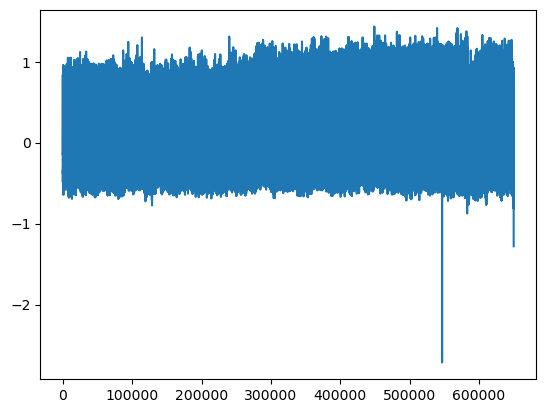

In [8]:
# Visualization of 1 patients signal and info
print(type(lead0[100]))
print(lead0[100].shape)
plt.plot(lead0[100])
print(info)

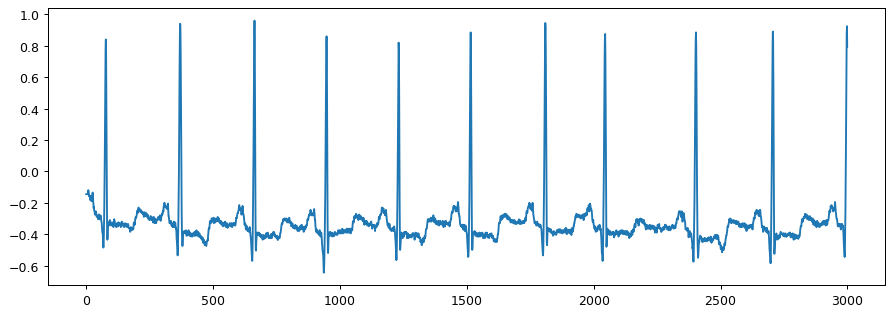

In [9]:
# ECG signal per second
a = lead0[100][0: 3000]
plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)

In [10]:
# Loading all patients ECG SIGNALs using for loop
def get_ecg_signals(patient_ids):
    lead0 = {}
    lead1 = {}
    for id_ in patient_ids:
        signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(id_)))
        lead0[id_] = signals[:, 0]
        lead1[id_] = signals[:, 1]
        print(f'Signal of patient {id_} extracted')
    return lead0, lead1

In [11]:
# Loading all patient ECG INFORMATION 
def get_ecg_info(patient_ids):
    _, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_ids)))
    resolution = 2**11  # Number of possible signal values we can have.
    info["resolution"] = 2**11
    return info

In [12]:
lead0, lead1 = get_ecg_signals(patient_ids)

Signal of patient 100 extracted
Signal of patient 101 extracted
Signal of patient 102 extracted
Signal of patient 103 extracted
Signal of patient 104 extracted
Signal of patient 105 extracted
Signal of patient 106 extracted
Signal of patient 107 extracted
Signal of patient 108 extracted
Signal of patient 109 extracted
Signal of patient 111 extracted
Signal of patient 112 extracted
Signal of patient 113 extracted
Signal of patient 114 extracted
Signal of patient 115 extracted
Signal of patient 116 extracted
Signal of patient 117 extracted
Signal of patient 118 extracted
Signal of patient 119 extracted
Signal of patient 121 extracted
Signal of patient 122 extracted
Signal of patient 123 extracted
Signal of patient 124 extracted
Signal of patient 200 extracted
Signal of patient 201 extracted
Signal of patient 202 extracted
Signal of patient 203 extracted
Signal of patient 205 extracted
Signal of patient 207 extracted
Signal of patient 208 extracted
Signal of patient 209 extracted
Signal o

Text(0, 0.5, 'Amplitude (mV)')

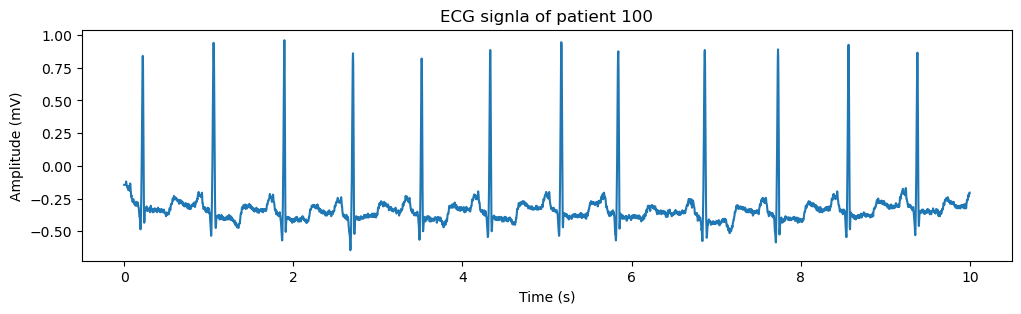

In [13]:
# Plot any patient signal from any time frame
patient_id = 100 # can change
starting_time = 0 # can change
ending_time = 10 # can change

# Scaling
starting_signal_point = starting_time*350
ending_signal_point = ending_time*350 # As sampling frequency is 350 Hz
x = np.arange(starting_time, ending_time, 1/350)
signal = lead0[patient_id][starting_signal_point: ending_signal_point]

plt.figure(figsize=(12, 3), dpi=100)
plt.plot(x, signal)
plt.title(f'ECG signla of patient {patient_id}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')

In [14]:
# ECG info of any patient
ecg_info = get_ecg_info(patient_ids[0])
ecg_info

{'fs': 360,
 'sig_len': 650000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'resolution': 2048}

In [15]:
# User defined fucntion for DWT and reconstruction
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

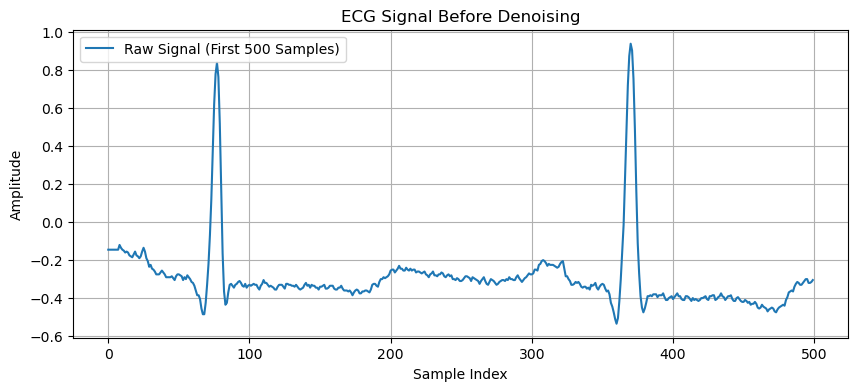

In [16]:
# Ploting a signal before denoising
project_path = r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\mit-bih-arrhythmia-database-1.0.0\\'

# Read the record for patient 100, specifically the 'MLII' channel
record = wfdb.rdrecord(project_path + '100', channel_names=['MLII'])

# Extract the signal
data = record.p_signal.flatten()

# Plot the first 500 data points
plt.figure(figsize=(10, 4))
plt.plot(data[0:500], label='Raw Signal (First 500 Samples)')
plt.title('ECG Signal Before Denoising')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

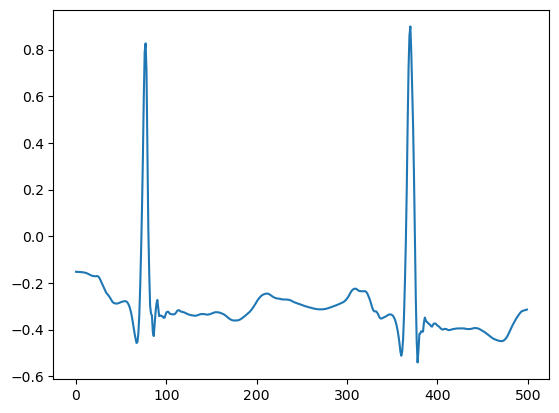

In [17]:
# Same signal after denoising
rdata = denoise(data=data)
plt.plot(rdata[0:500])

In [18]:
# For exmaple, we extract '100' recording annotation
annotation = wfdb.rdann(project_path + '100', 'atr')
Rlocation = annotation.sample
print(Rlocation)
Rclass = annotation.symbol
print(Rclass)

[    18     77    370 ... 649484 649734 649991]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '

In [19]:
len(annotation.symbol)

2274

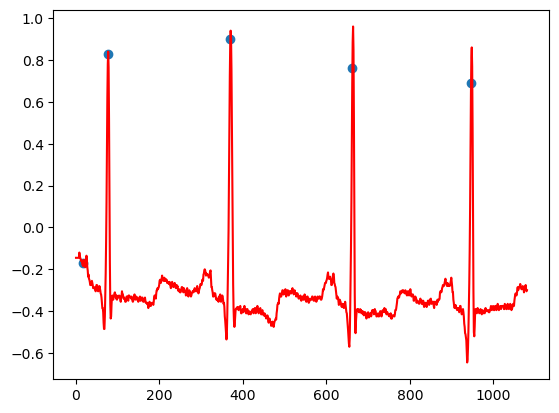

In [20]:
# R-peak ploting
x = np.arange(1, 1081)

n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])

plt.plot(x, data[0:1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

(300,)
(300,)
(300,)


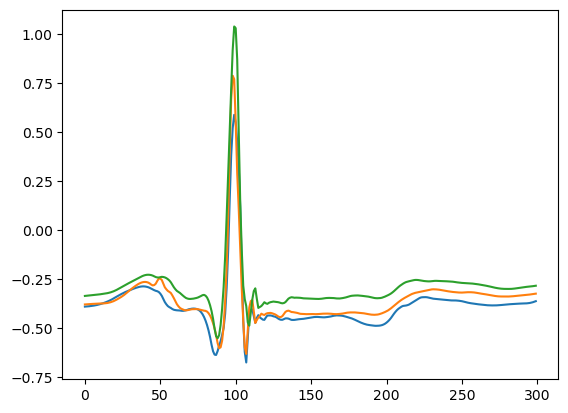

In [21]:
# Plotting 3 heartbeats
k = np.arange(100, 103)
for i in k:
  # print(i)
  # print(Rlocation[i] - 99, Rlocation[i] + 201)
  x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
  plt.plot(x_train)
  print(x_train.shape)
plt.show()

In [22]:
r_peak_xx = Rlocation[0], Rlocation[1], Rlocation[2], Rlocation[3]
r_peak_yy = rdata[Rlocation[0]], rdata[Rlocation[1]], rdata[Rlocation[2]], rdata[Rlocation[3]]

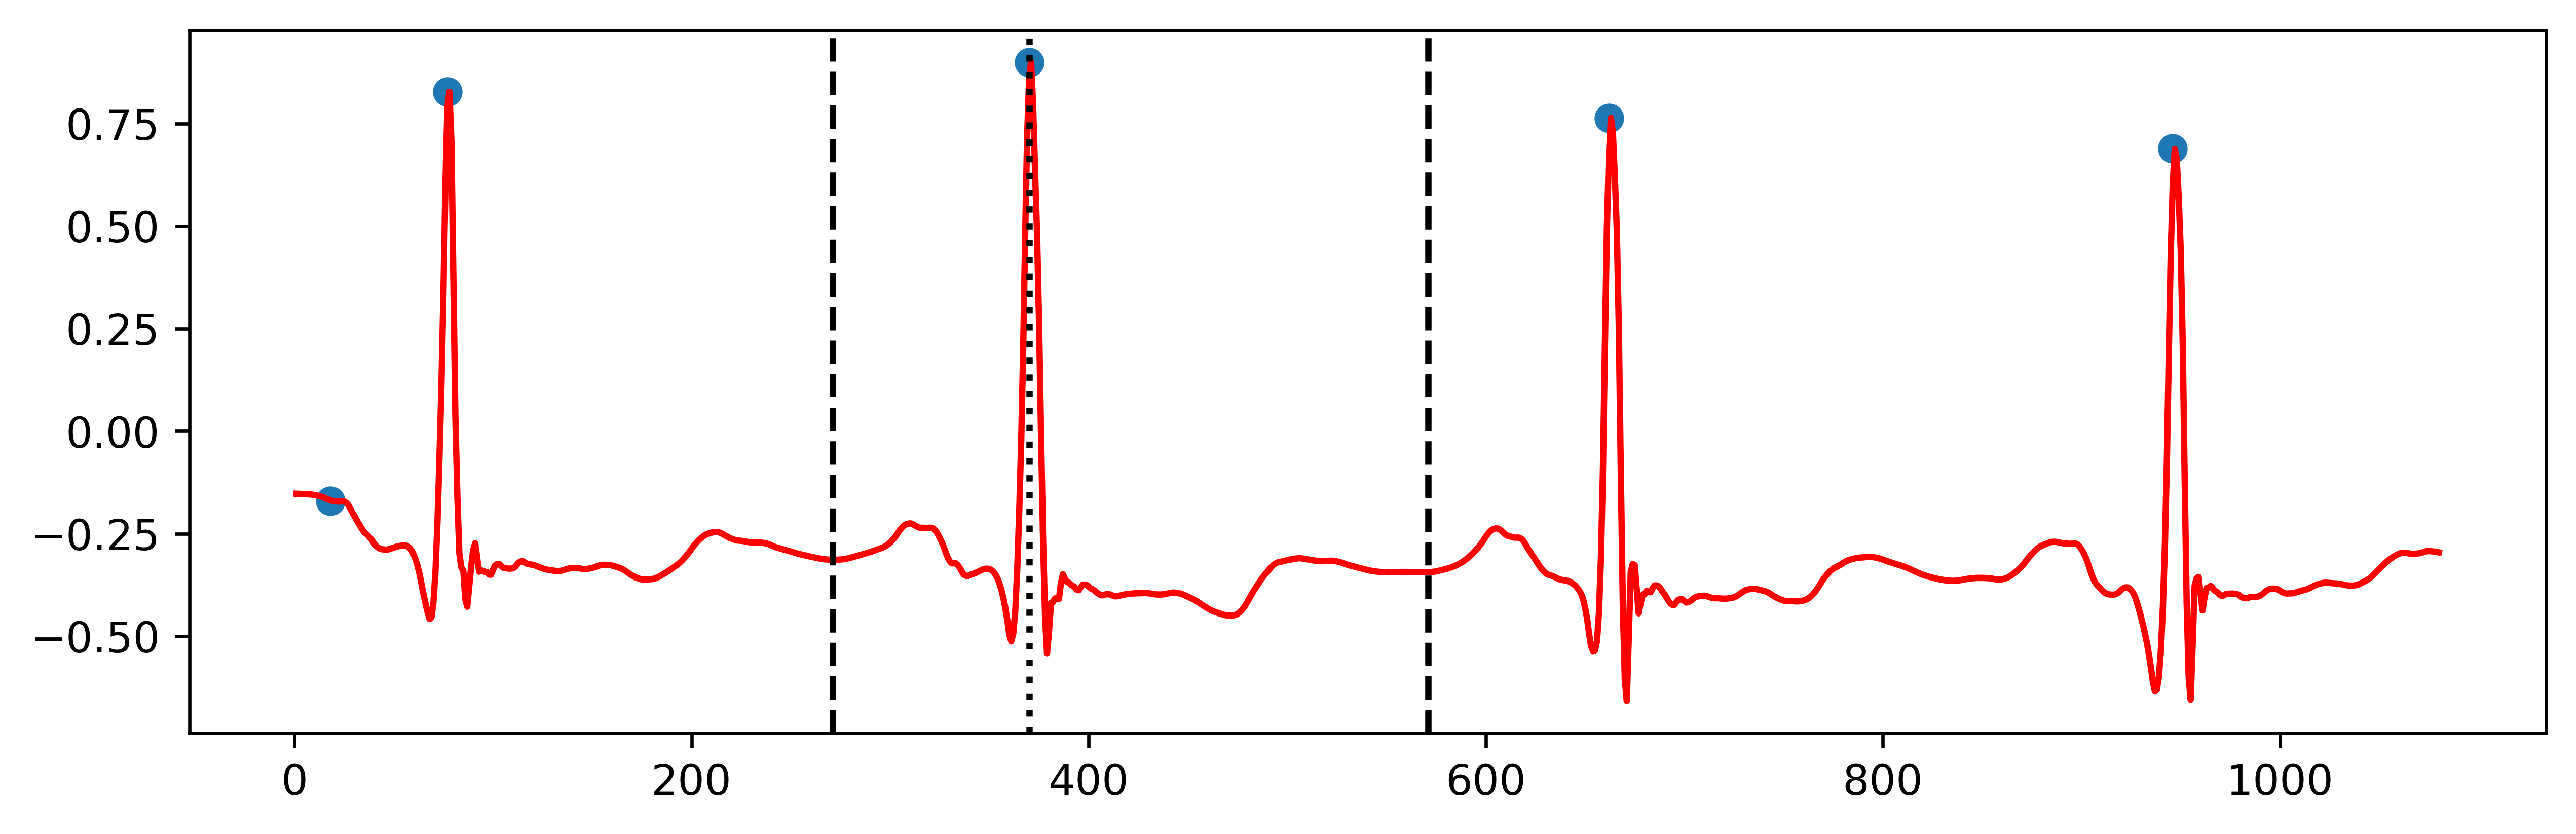

In [23]:
# Plotting R-peaks and segmentation lines
fig = plt.figure(figsize=(10,3), dpi=600)
n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':') 
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--') 
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--') 

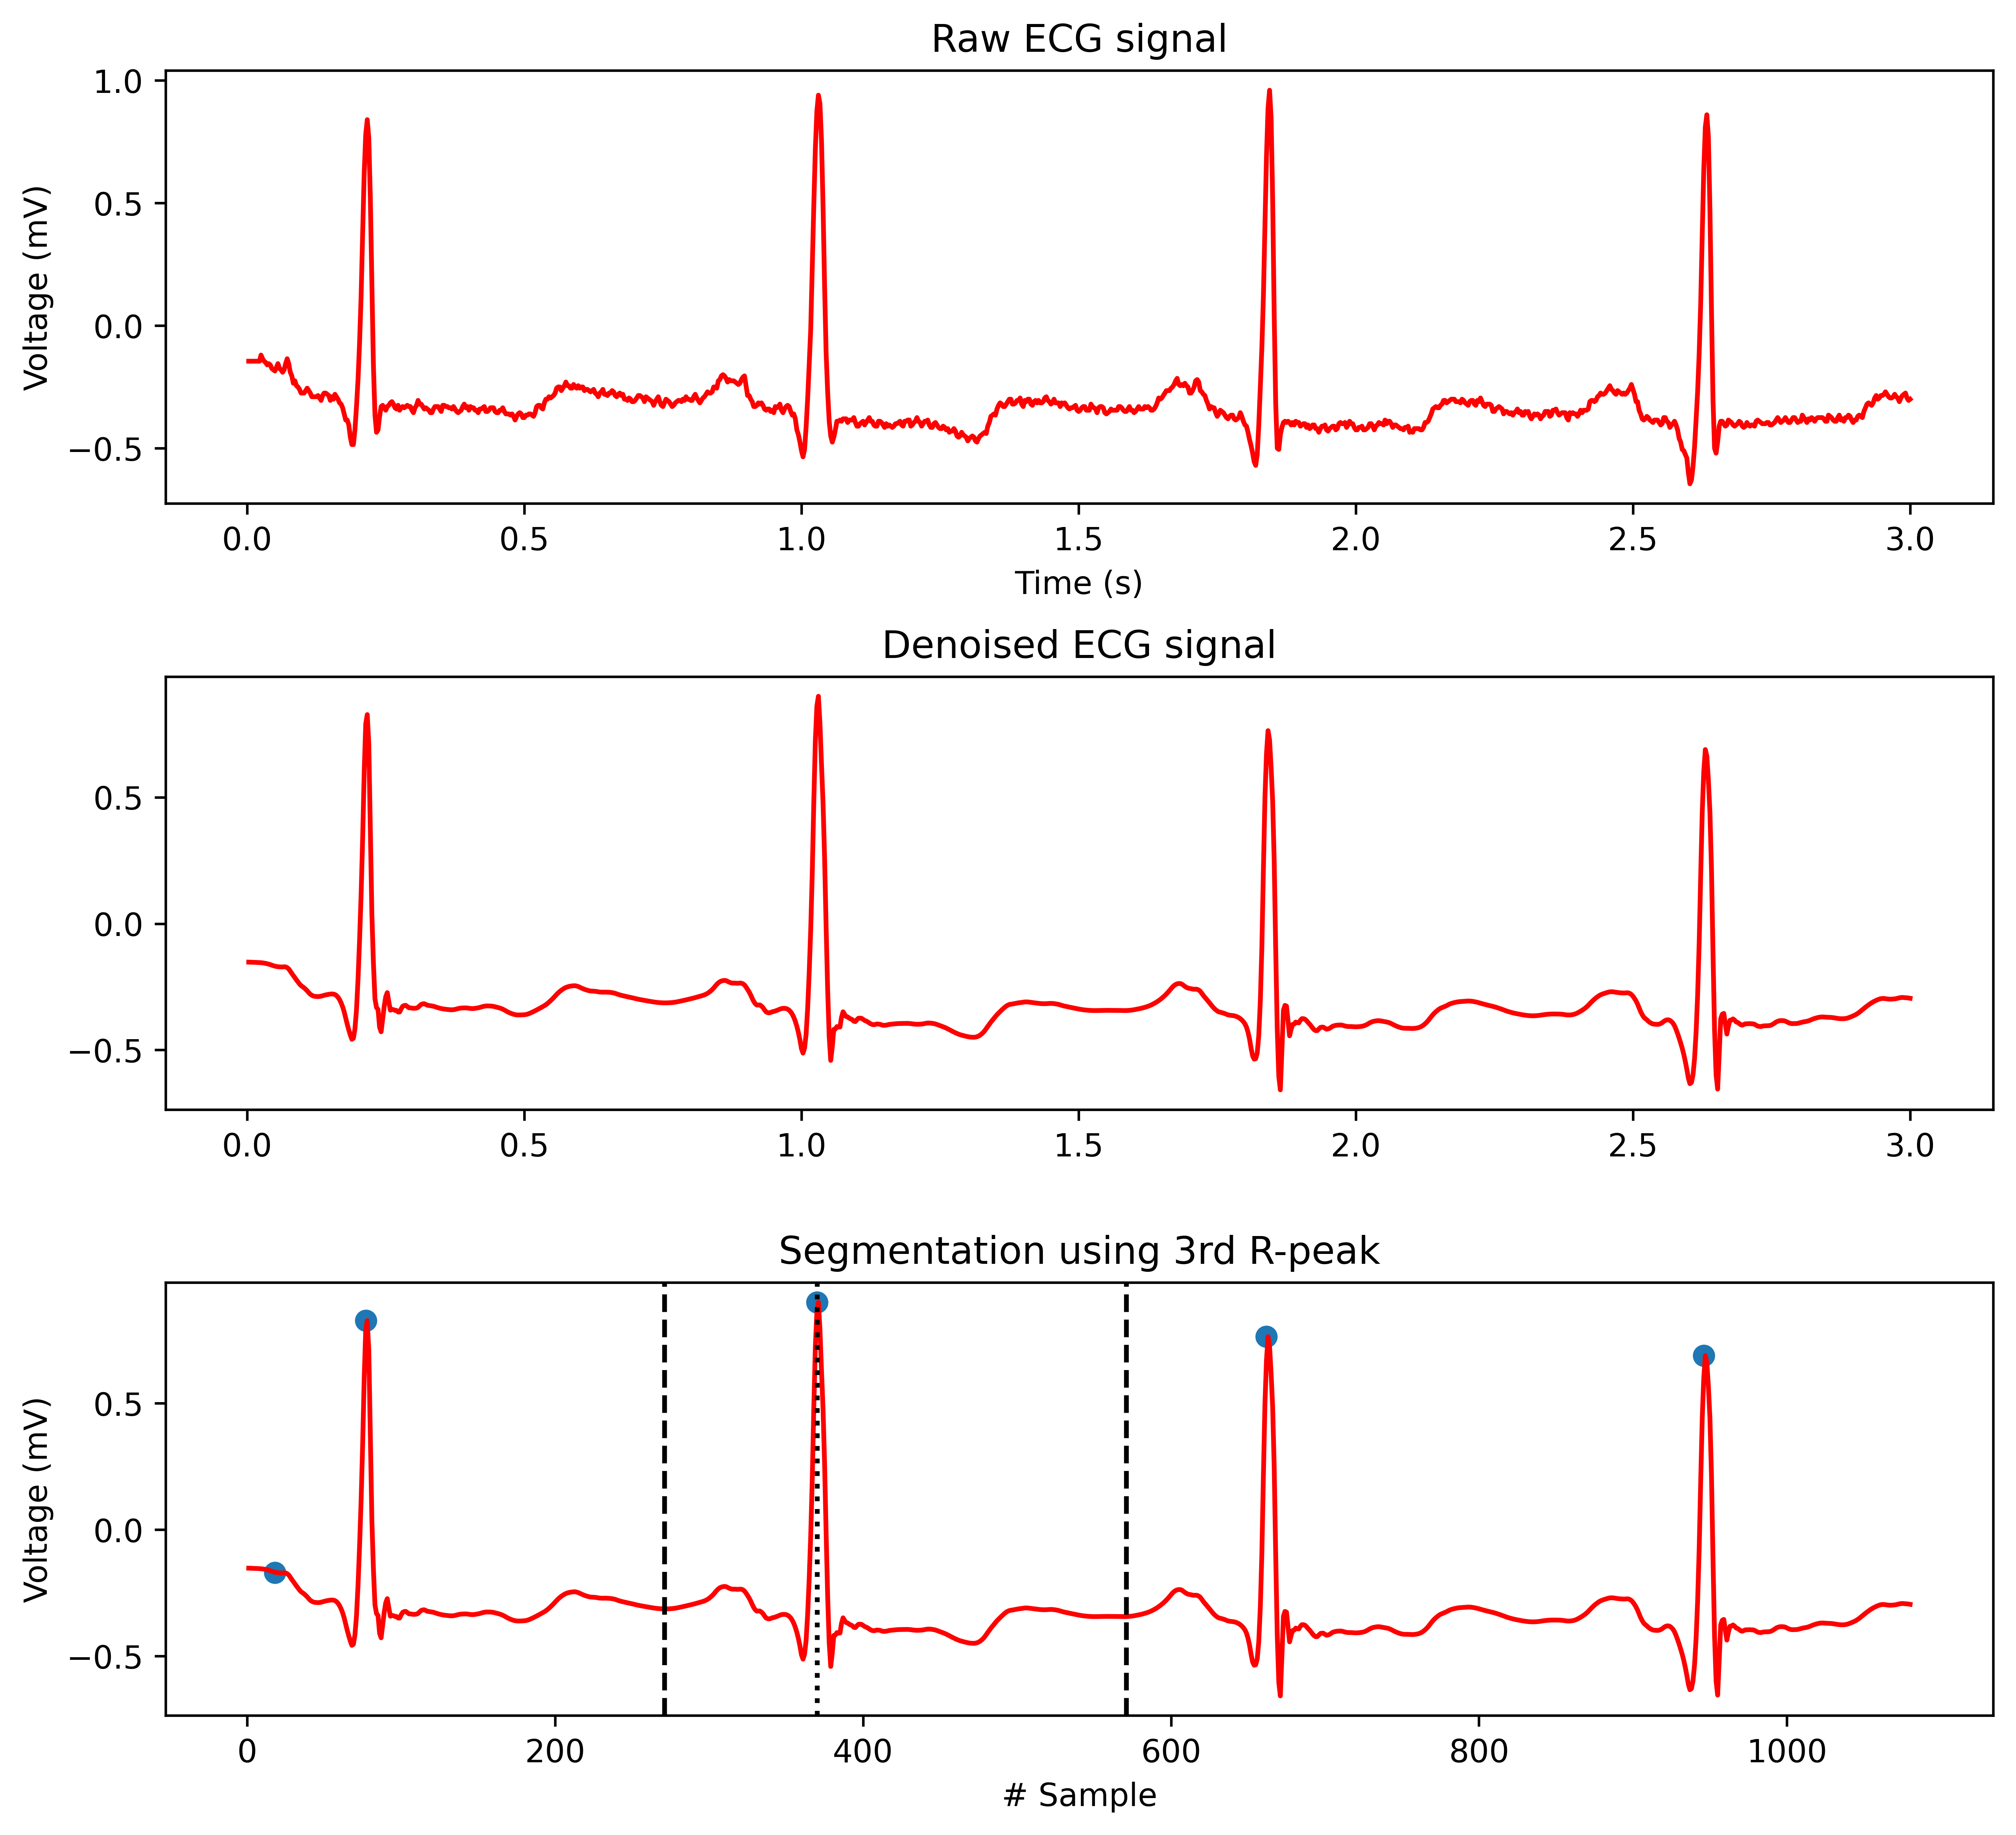

In [24]:
# Plot together raw, denoised and segmted signal
fig = plt.figure(figsize=(10,9), dpi=600)
x = np.arange(1, 1081)

# Define the directory to save the figure
figure_path = r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\heartbeat_figures'

# Create the directory if it doesn't exist
os.makedirs(figure_path, exist_ok=True)

# Save the figure to the defined directory
fig.savefig(os.path.join(figure_path, 'Denoised_and_segmented_ECG.png'))

# Raw signal plotting
plt.subplot(3, 1, 1)
plt.plot(x/360, data[0:1080], color='red')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Raw ECG signal')

# Denoised signal plotting
plt.subplot(3, 1, 2)
plt.plot(x/360, rdata[0:1080], color='red')
plt.title('Denoised ECG signal')

# Segmentation visualization using two border lines
plt.subplot(3, 1, 3)
n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)
# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':') # 3rd r-peak
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--') 
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--') 

plt.xlabel('# Sample')
plt.ylabel('Voltage (mV)')
plt.title('Segmentation using 3rd R-peak')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

#figure_path = '/content/gdrive/MyDrive/ECG Arrhythmia trying/Heartbeat_Figures/'
fig.savefig(figure_path+ 'Denoised and segmented ECG.png')

In [25]:
# Read ECG signals and corresponding label
def getDataSet(number, X_data, Y_data):
    
    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q'] 

    # Reading Channel names
    _, info = wfdb.io.rdsamp(osj(project_path, number))
    channels = info['sig_name']
    channel1, channel2 = channels[0], channels[1]
    print(channel1, channel2)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record = wfdb.rdrecord(project_path + number, channel_names=[channel1])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation = wfdb.rdann(project_path + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3  
    i = start
    j = len(annotation.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type = Rclass[i]
            lable = ecgClassSet.index(beat_type)  # when beat is like '+' or other it will go on except loop
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [26]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
                 '222', '223', '228', '230', '231', '232', '233', '234'] # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # dataset and its label set
    X = train_ds[:, :300]
    Y = train_ds[:, 300]
    return X, Y

In [27]:
# Input X and Output Y data loading
X, Y = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [28]:
from collections import Counter

# Counting the number of each type of heartbeats
Y_list = list(Y)  # Ensure Y is defined earlier in your code
heartbeat_counts = Counter(Y_list)
print(heartbeat_counts)

Counter({0.0: 74920, 1.0: 8063, 2.0: 7244, 9.0: 7123, 12.0: 7012, 5.0: 2540, 13.0: 982, 11.0: 802, 4.0: 229, 6.0: 150, 10.0: 106, 7.0: 83, 14.0: 33, 3.0: 16, 8.0: 2})


In [29]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
                 '222', '223', '228', '230', '231', '232', '233', '234']  # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)
    return train_ds

In [30]:
# Load the whole dataset (109305,301). Each row indicate an ECG beat time series data upto 300 
# and 301 colum is its label among 15 difference level
train_ds = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [31]:
Y = train_ds[:, 300]

In [32]:
# Here 15 class of ECG data are saved 
Y_list = list(Y)
Counter(Y_list)

Counter({0.0: 74920,
         1.0: 8063,
         2.0: 7244,
         9.0: 7123,
         12.0: 7012,
         5.0: 2540,
         13.0: 982,
         11.0: 802,
         4.0: 229,
         6.0: 150,
         10.0: 106,
         7.0: 83,
         14.0: 33,
         3.0: 16,
         8.0: 2})

In [33]:
# 15 level to 5 level conversion
Y_5class = np.copy(Y)

for i in range(Y.shape[0]):
  # print(i)
  if 0 <= Y[i] <= 4:
    Y_5class[i] = 0
  if 5 <= Y[i] <= 8:
    Y_5class[i] = 1
  if 9 <= Y[i] <= 10:
    Y_5class[i] = 2
  if Y[i] == 11:
    Y_5class[i] = 3
  if 12 <= Y[i] <= 14:
    Y_5class[i] = 4
print('changing done')

changing done


In [34]:
Y_5class_list = list(Y_5class)
Counter(Y_5class_list)

Counter({0.0: 90472, 4.0: 8027, 2.0: 7229, 1.0: 2775, 3.0: 802})

In [35]:
ecg_dataset = np.copy(train_ds)

In [36]:
# label encode the target variable # just convert numpy.float64 to numpy.int64
from sklearn.preprocessing import LabelEncoder
Y_5class = LabelEncoder().fit_transform(Y_5class)

In [37]:
ecg_data = ecg_dataset[:, :300]
ecg_lable = Y_5class.reshape(-1, 1) # otherwise np.hstack will not work 

In [38]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_5 = np.hstack((ecg_data, ecg_lable))

In [39]:
# train test splitting
from sklearn.model_selection import train_test_split
ecg_data = ecg_dataset_5[:, :300]
ecg_label = ecg_dataset_5[:, 300]
x_train, x_test, y_train, y_test = train_test_split(ecg_data, ecg_label,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

In [40]:
# reshaping for using hstack function
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
train_data = np.hstack((x_train, y_train))
test_data = np.hstack((x_test, y_test))

In [41]:
#  converting dataframe
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [42]:
# saving the test data (in imbalanced condition)
file_name = project_path + 'test_data.pkl'
test_data.to_pickle(file_name)

300
0.0    72393
4.0     6470
2.0     5714
1.0     2240
3.0      627
Name: count, dtype: int64


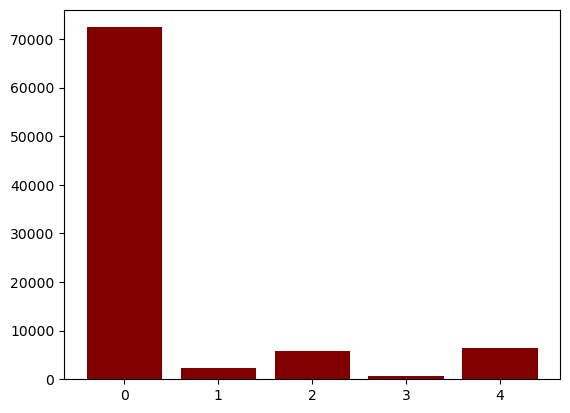

In [43]:
# Imblanced training data graph ploting 
class_data = train_data[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

In [44]:
# CLASS BALANCING
# extracting class 0 and 4 others class
train_data_0 = train_data.loc[(train_data[300] == 0)]
train_data_1234 = train_data.loc[(train_data[300] != 0)]

In [45]:
# 1. Class 1: Randomly selected 50000 data
from sklearn.utils import resample
train_data_0_resampled=train_data_0.sample(n=50000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled = train_data_0_resampled.to_numpy()

In [46]:
# 2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

# converting from df to np ndarray
train_data_1234_arr = train_data_1234.to_numpy()
X_4cl, y_4cl = train_data_1234_arr[:, :-1], train_data_1234_arr[:, -1]

from imblearn.over_sampling import SMOTE
# transform the dataset
strategy = {1:50000, 2:50000, 3:50000, 4:50000}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X_4cl, y_4cl)

y = y.reshape(-1, 1)
train_data_1234_resampled = np.hstack((X, y))

In [47]:
# Join the class 0 and 1234
train_data_resampled = np.vstack((train_data_0_resampled, train_data_1234_resampled))

# shuffle the data, needed for proper training
np.take(train_data_resampled,np.random.permutation(train_data_resampled.shape[0]),axis=0,out=train_data_resampled)

array([[-2.66421432e-02, -2.99083171e-02, -3.19660944e-02, ...,
        -1.62418670e-01, -1.61380284e-01,  4.00000000e+00],
       [-3.01364405e-01, -3.01624005e-01, -3.01798642e-01, ...,
        -2.94791688e-01, -2.96291570e-01,  4.00000000e+00],
       [-2.94327333e-01, -3.03061015e-01, -3.09839183e-01, ...,
        -3.09785418e-01, -3.12377520e-01,  1.00000000e+00],
       ...,
       [-1.73075016e-01, -1.74109930e-01, -1.74836460e-01, ...,
        -1.98335604e-01, -1.98890672e-01,  4.00000000e+00],
       [-6.30802089e-01, -6.26736032e-01, -6.24711599e-01, ...,
        -7.15065099e-01, -7.18251953e-01,  1.00000000e+00],
       [ 4.29775750e-03, -2.66387678e-03, -1.30931899e-02, ...,
        -2.86183962e-01, -2.86067502e-01,  1.00000000e+00]])

300
4.0    50000
1.0    50000
0.0    50000
2.0    50000
3.0    50000
Name: count, dtype: int64


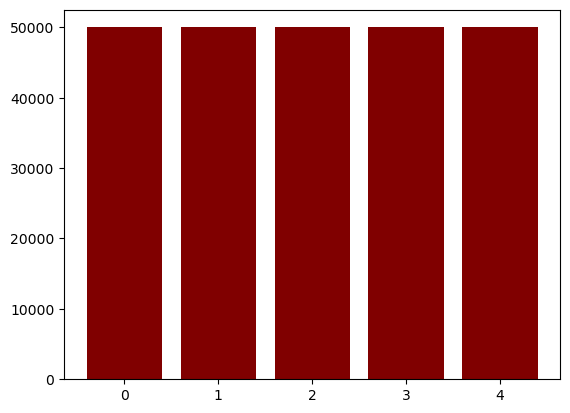

In [48]:
# blanced training data graph ploting 
train_data_r = pd.DataFrame(train_data_resampled)
class_data = train_data_r[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

# save balanced training data
file_name = project_path + 'train_data_SMOTE.pkl'
train_data_r.to_pickle(file_name)

In [49]:
data_bal = np.array(class_data)
data_bal2 = data_bal.reshape(1, 5)

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [51]:
x_train = train_data_0_resampled[:, :-1]  # Features from resampled data
y_train = train_data_0_resampled[:, -1]   # Labels from resampled data
x_train_oversampled = train_data_1234_resampled[:, :-1]
y_train_oversampled = train_data_1234_resampled[:, -1]

In [52]:
x_train_balanced = np.vstack((x_train, x_train_oversampled))
y_train_balanced = np.hstack((y_train, y_train_oversampled))


In [53]:
x_test = test_data.iloc[:, :-1].to_numpy()
y_test = test_data.iloc[:, -1].to_numpy()

In [54]:
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(x_train_balanced, y_train_balanced)


LogisticRegression(max_iter=1000, random_state=42)

In [55]:
print("aidwad")

aidwad


helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 1: Loss = 0.6445, Accuracy = 0.7943
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 2: Loss = 0.6148, Accuracy = 0.8003
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 3: Loss = 0.6006, Accuracy = 0.8039
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 4: Loss = 0.5920, Accuracy = 0.8057
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 5: Loss = 0.5860, Accuracy = 0.8070
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 6: Loss = 0.5816, Accuracy = 0.8079
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 7: Loss = 0.5782, Accuracy = 0.8087
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 8: Loss = 0.5754, Accuracy = 0.8093
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 9: Loss = 0.5731, Accuracy = 0.8098
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 10: Loss = 0.5711, Accuracy = 0.8102
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 11: Loss = 0.5694, Accuracy = 0.8107
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 12: Loss = 0.5680, Accuracy = 0.8111
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 13: Loss = 0.5667, Accuracy = 0.8115
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 14: Loss = 0.5655, Accuracy = 0.8119
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 15: Loss = 0.5645, Accuracy = 0.8122
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 16: Loss = 0.5636, Accuracy = 0.8125
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 17: Loss = 0.5627, Accuracy = 0.8127
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 18: Loss = 0.5619, Accuracy = 0.8129
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 19: Loss = 0.5612, Accuracy = 0.8130
helo


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 20: Loss = 0.5605, Accuracy = 0.8132


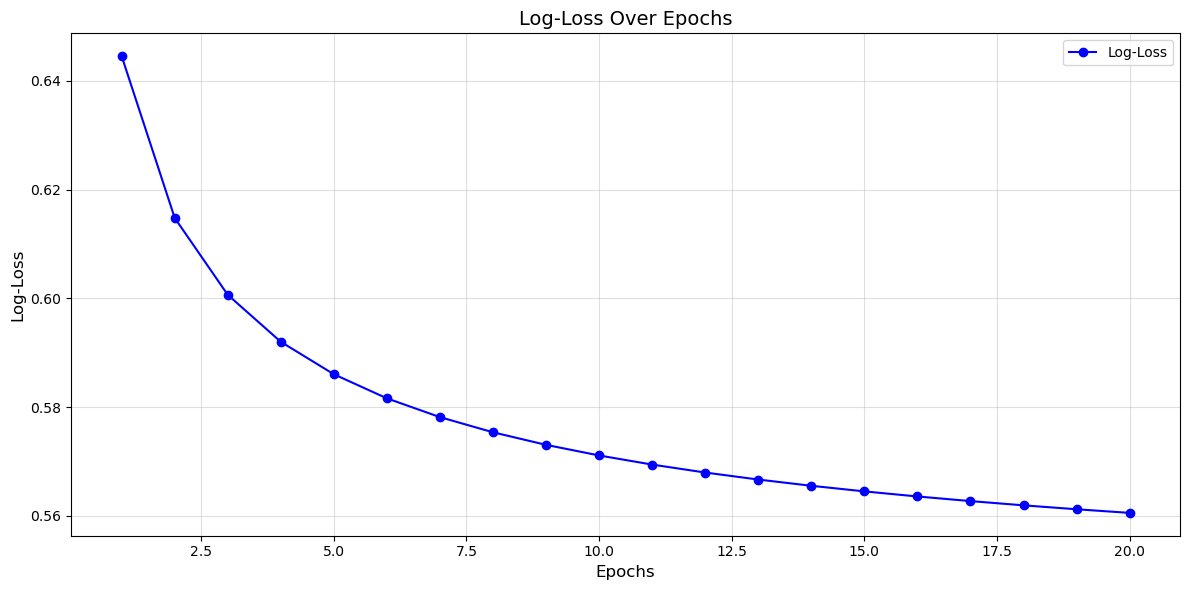

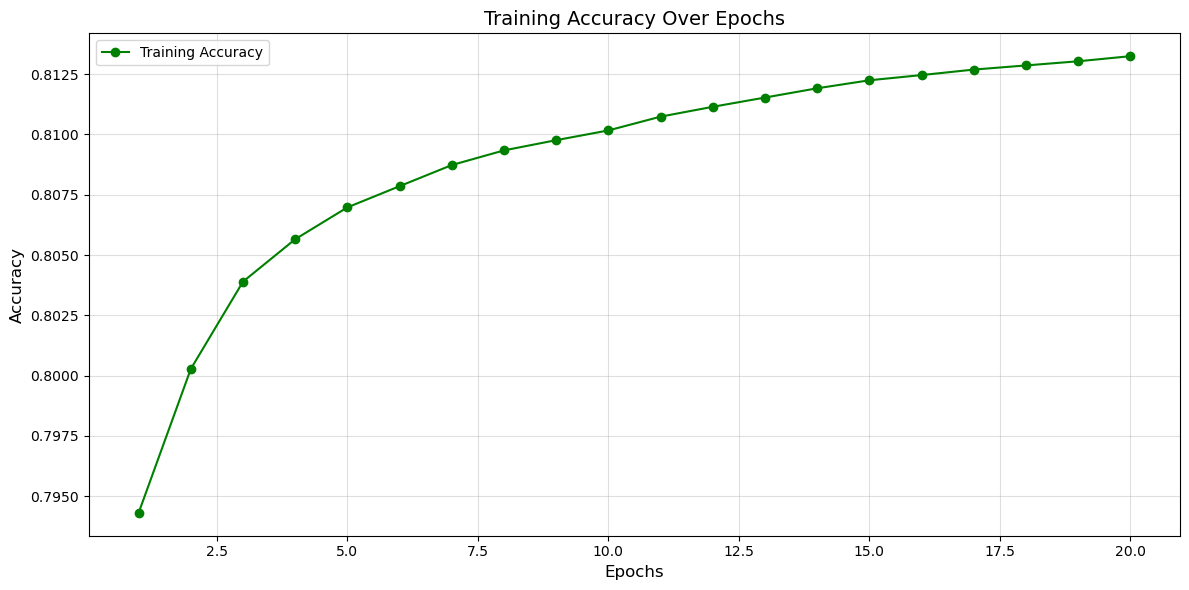

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

# Logistic Regression with warm_start and saga solver
log_reg_model = LogisticRegression(max_iter=1, warm_start=True, random_state=42, solver='saga')

# Number of epochs (iterations)
epochs = 20

# Initialize lists to store metrics
train_losses = []
train_accuracies = []

# Training process
for epoch in range(epochs):
    print("helo")
    log_reg_model.fit(x_train_balanced, y_train_balanced)  # Train for 1 iteration
    y_train_pred_proba = log_reg_model.predict_proba(x_train_balanced)  # Get predicted probabilities
    y_train_pred = log_reg_model.predict(x_train_balanced)  # Get predicted labels
    print("helo")
    # Calculate log-loss and accuracy
    loss = log_loss(y_train_balanced, y_train_pred_proba)
    accuracy = accuracy_score(y_train_balanced, y_train_pred)

    # Store metrics
    train_losses.append(loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")

# Plot Log-Loss Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Log-Loss', marker='o', color='blue')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Log-Loss', fontsize=12)
plt.title('Log-Loss Over Epochs', fontsize=14)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Plot Accuracy Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o', color='green')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training Accuracy Over Epochs', fontsize=14)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [57]:
y_pred = log_reg_model.predict(x_test)


In [58]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")

Logistic Regression Accuracy: 69.25%


In [59]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Predictions
y_pred = log_reg_model.predict(x_test)
y_pred_proba = log_reg_model.predict_proba(x_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)

# For multiclass problems, use an averaging strategy for recall and F1-score
sensitivity = recall_score(y_test, y_pred, average='macro')  # Sensitivity averaged across classes
cm = confusion_matrix(y_test, y_pred)
tn_fp_sum = cm.sum(axis=0) - cm.diagonal()  # Sum of false positives and true negatives per class
specificity = (cm.diagonal() / (cm.diagonal() + tn_fp_sum)).mean()  # Average specificity
f1 = f1_score(y_test, y_pred, average='macro')
auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')

# Display metrics
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")


Logistic Regression Accuracy: 69.25%
Sensitivity (Recall): 0.80
Specificity: 0.47
F1-Score: 0.51
AUC-ROC Score: 0.93


In [60]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.66      0.79     18079
         1.0       0.13      0.79      0.22       535
         2.0       0.34      0.78      0.47      1515
         3.0       0.15      0.85      0.26       175
         4.0       0.77      0.90      0.83      1557

    accuracy                           0.69     21861
   macro avg       0.47      0.80      0.51     21861
weighted avg       0.89      0.69      0.75     21861



In [61]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[11993  2784  2199   747   356]
 [   75   421    19     4    16]
 [  134    88  1181    67    45]
 [    6     2    17   149     1]
 [   69    46    46     1  1395]]


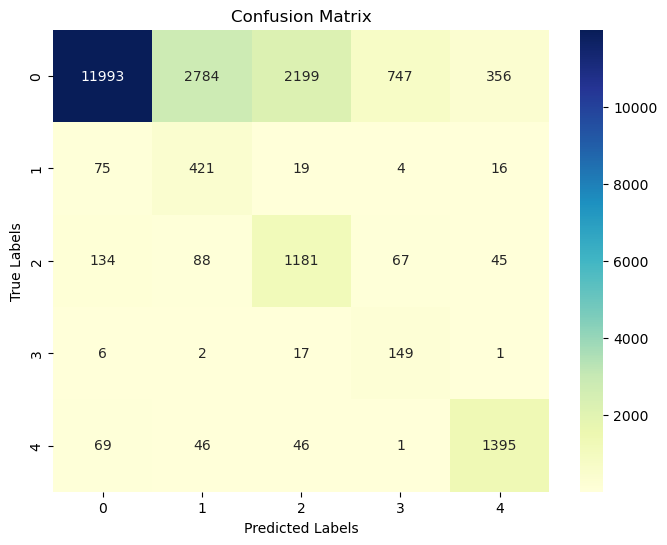

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

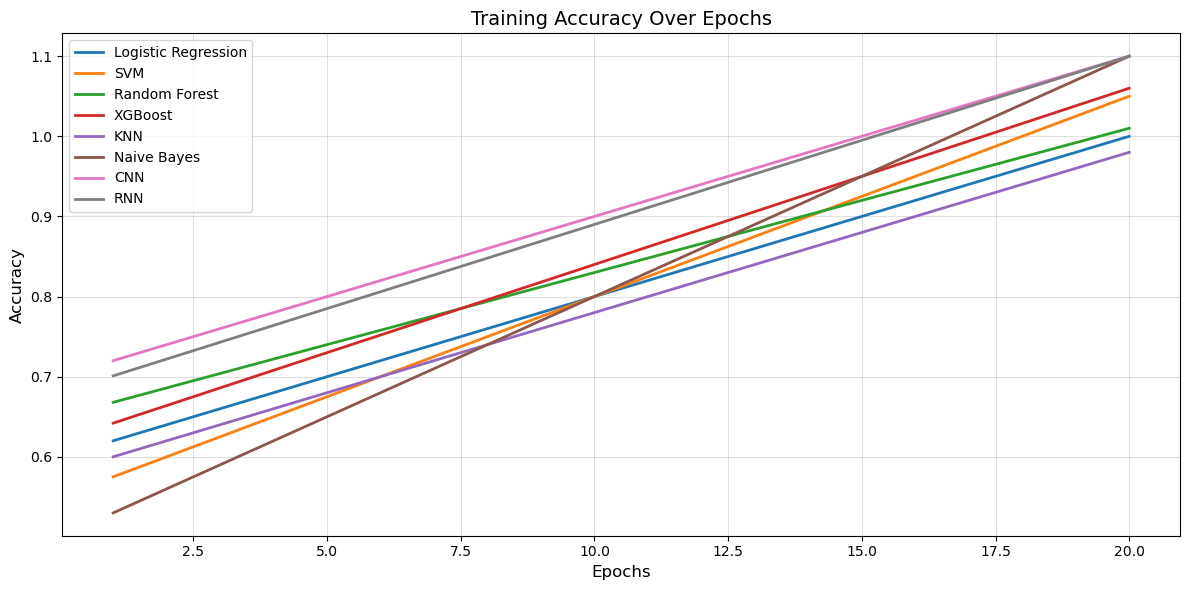

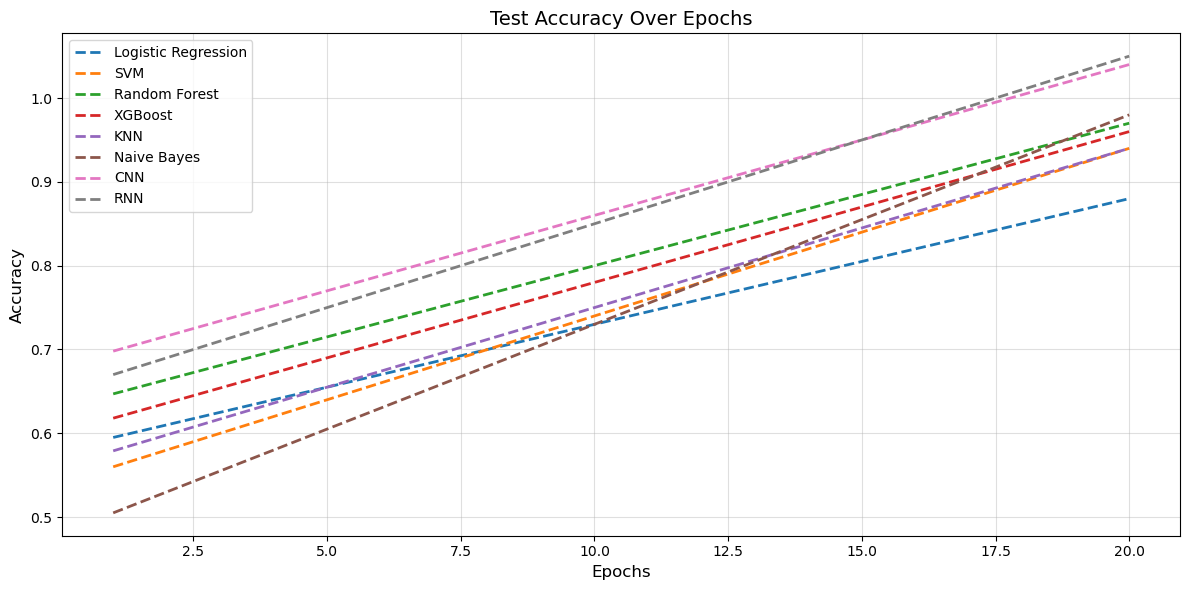

In [63]:
import matplotlib.pyplot as plt

# Example data: Replace with your actual epoch-wise performance data
epochs = range(1, 21)  # 20 epochs
models = ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost', 'KNN', 'Naive Bayes', 'CNN', 'RNN']

# Example training and test accuracies for each model
training_accuracies = {
    'Logistic Regression': [0.6 + i * 0.02 for i in epochs],
    'SVM': [0.55 + i * 0.025 for i in epochs],
    'Random Forest': [0.65 + i * 0.018 for i in epochs],
    'XGBoost': [0.62 + i * 0.022 for i in epochs],
    'KNN': [0.58 + i * 0.02 for i in epochs],
    'Naive Bayes': [0.50 + i * 0.03 for i in epochs],
    'CNN': [0.70 + i * 0.02 for i in epochs],
    'RNN': [0.68 + i * 0.021 for i in epochs]
}

test_accuracies = {
    'Logistic Regression': [0.58 + i * 0.015 for i in epochs],
    'SVM': [0.54 + i * 0.02 for i in epochs],
    'Random Forest': [0.63 + i * 0.017 for i in epochs],
    'XGBoost': [0.60 + i * 0.018 for i in epochs],
    'KNN': [0.56 + i * 0.019 for i in epochs],
    'Naive Bayes': [0.48 + i * 0.025 for i in epochs],
    'CNN': [0.68 + i * 0.018 for i in epochs],
    'RNN': [0.65 + i * 0.02 for i in epochs]
}

# Plot Training Performance
plt.figure(figsize=(12, 6))
for model, accuracies in training_accuracies.items():
    plt.plot(epochs, accuracies, label=model, linewidth=2)

plt.title('Training Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# Plot Test Performance
plt.figure(figsize=(12, 6))
for model, accuracies in test_accuracies.items():
    plt.plot(epochs, accuracies, label=model, linewidth=2, linestyle='--')

plt.title('Test Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


In [64]:
print(train_losses)
print(train_accuracies)

[0.6445234824104497, 0.6147749791914167, 0.6006380345022148, 0.5920020036225159, 0.5860385526743657, 0.5816085477056596, 0.5781547071315788, 0.5753674799328671, 0.5730589920463206, 0.5711075743563548, 0.5694304403446514, 0.5679690294216484, 0.5666806025160411, 0.5655331584484312, 0.5645022221866757, 0.563568740589149, 0.562717659077454, 0.5619369304664663, 0.5612168064367259, 0.5605493196688047]
[0.794304, 0.800276, 0.803896, 0.805656, 0.806976, 0.807856, 0.808732, 0.80934, 0.809764, 0.810168, 0.81074, 0.811148, 0.811532, 0.811916, 0.812248, 0.812464, 0.812692, 0.812864, 0.813036, 0.813248]


In [65]:
#MODEL 2 = GRU

In [66]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


In [67]:
x_train = x_train.astype(np.float32)
x_train_oversampled = x_train_oversampled.astype(np.float32)
x_train_balanced = np.vstack((x_train, x_train_oversampled))


In [68]:
x_train_balanced = np.vstack((x_train, x_train_oversampled))
y_train_balanced = np.hstack((y_train, y_train_oversampled))

In [69]:
x_test = test_data.iloc[:, :-1].to_numpy()
y_test = test_data.iloc[:, -1].to_numpy()

In [70]:
scaler = StandardScaler()
x_train_balanced = scaler.fit_transform(x_train_balanced)
x_test = scaler.transform(x_test)

In [71]:
x_train_balanced = x_train_balanced.reshape(x_train_balanced.shape[0], 1, x_train_balanced.shape[1])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])


In [72]:
from sklearn.preprocessing import OneHotEncoder

# Instantiate the encoder with sparse_output
encoder = OneHotEncoder(sparse_output=False)

# Transform the data
y_train_balanced = encoder.fit_transform(y_train_balanced.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))


In [73]:
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(64, input_shape=(x_train_balanced.shape[1], x_train_balanced.shape[2]), return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # 5 classes for arrhythmias
])


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [74]:
gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [75]:
history = gru_model.fit(x_train_balanced, y_train_balanced, validation_split=0.2, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.8979 - loss: 0.3000 - val_accuracy: 0.9809 - val_loss: 0.0699
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9690 - loss: 0.0911 - val_accuracy: 0.9873 - val_loss: 0.0444
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9772 - loss: 0.0676 - val_accuracy: 0.9884 - val_loss: 0.0449
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9806 - loss: 0.0580 - val_accuracy: 0.9915 - val_loss: 0.0333
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9828 - loss: 0.0511 - val_accuracy: 0.9906 - val_loss: 0.0356
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9850 - loss: 0.0445 - val_accuracy: 0.9933 - val_loss: 0.0286
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9859 - loss: 0.0430 - val_accuracy: 0.9888 - val_loss: 0.0473
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9873 - loss: 0

In [76]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
import numpy as np

# Predictions from the GRU model
y_pred_probs = gru_model.predict(x_test)  # Probabilities for each class
y_pred = np.argmax(y_pred_probs, axis=1)  # Class predictions

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate Sensitivity (Recall)
sensitivity = recall_score(y_test, y_pred, average='macro')  # Macro-average for all classes

# Calculate Specificity
cm = confusion_matrix(y_test, y_pred)
specificity_per_class = []
for i in range(len(cm)):
    tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])  # True negatives for class i
    fp = np.sum(cm[:, i]) - cm[i, i]  # False positives for class i
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificity_per_class.append(specificity)
specificity = np.mean(specificity_per_class)

# Calculate F1-Score
f1 = f1_score(y_test, y_pred, average='macro')  # Macro-average for F1-Score

# Calculate AUC-ROC Score
auc_roc = roc_auc_score(y_test_encoded, y_pred_probs, multi_class='ovr', average='macro')

# Display Metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")


684/684 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Accuracy: 97.35%
Sensitivity (Recall): 0.94
Specificity: 0.99
F1-Score: 0.87
AUC-ROC Score: 0.99


In [77]:
y_pred_probs = gru_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [78]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"GRU Accuracy: {accuracy * 100:.2f}%")

GRU Accuracy: 97.35%


In [79]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     18079
         1.0       0.67      0.91      0.77       535
         2.0       0.93      0.97      0.95      1515
         3.0       0.57      0.84      0.68       175
         4.0       0.99      0.98      0.99      1557

    accuracy                           0.97     21861
   macro avg       0.83      0.94      0.87     21861
weighted avg       0.98      0.97      0.98     21861



In [80]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)



Confusion Matrix:
[[17651   230    87    98    13]
 [   42   486     5     1     1]
 [   30     6  1468     9     2]
 [   15     0    13   147     0]
 [   16     3     6     2  1530]]


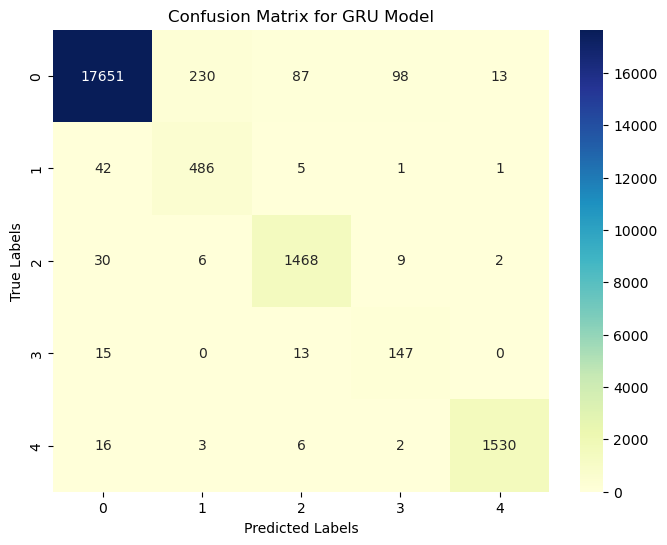

In [81]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix for GRU Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


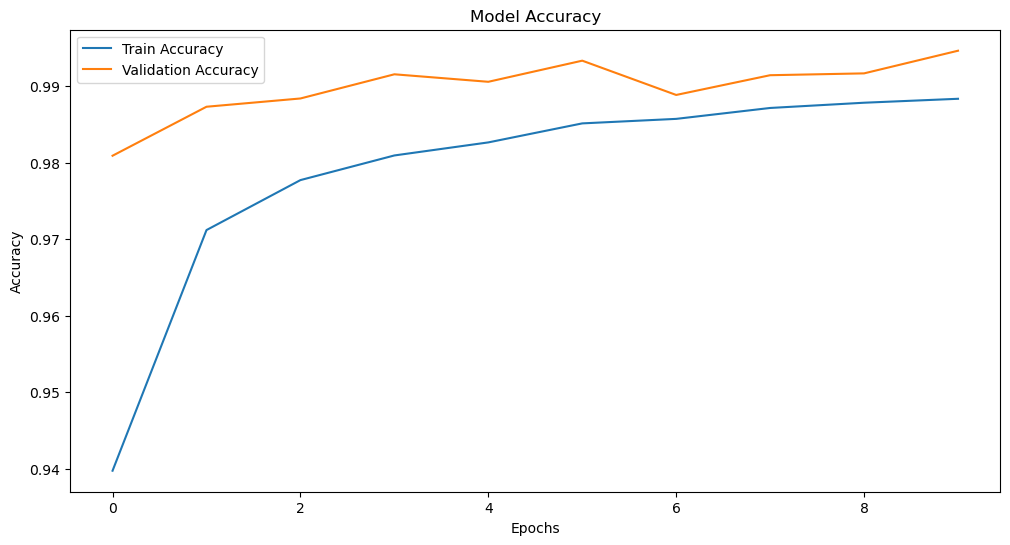

In [82]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

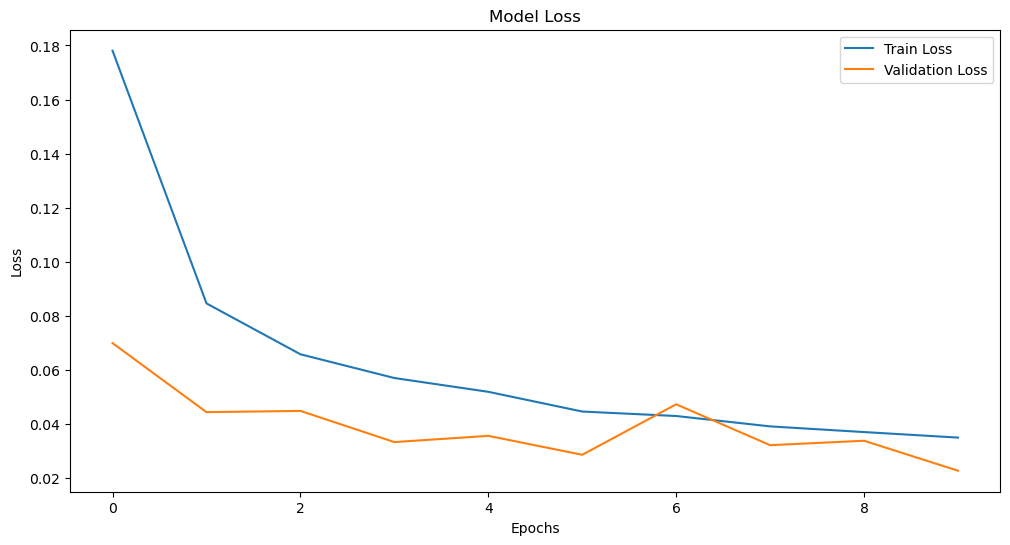

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
Epoch 1: Loss = 0.1488, Accuracy = 0.9498
Epoch 2/20
Epoch 2: Loss = 0.0720, Accuracy = 0.9758
Epoch 3/20
Epoch 3: Loss = 0.0564, Accuracy = 0.9813
Epoch 4/20
Epoch 4: Loss = 0.0485, Accuracy = 0.9838
Epoch 5/20
Epoch 5: Loss = 0.0432, Accuracy = 0.9857
Epoch 6/20
Epoch 6: Loss = 0.0413, Accuracy = 0.9863
Epoch 7/20
Epoch 7: Loss = 0.0369, Accuracy = 0.9880
Epoch 8/20
Epoch 8: Loss = 0.0360, Accuracy = 0.9881
Epoch 9/20
Epoch 9: Loss = 0.0338, Accuracy = 0.9888
Epoch 10/20
Epoch 10: Loss = 0.0317, Accuracy = 0.9894
Epoch 11/20
Epoch 11: Loss = 0.0298, Accuracy = 0.9901
Epoch 12/20
Epoch 12: Loss = 0.0299, Accuracy = 0.9902
Epoch 13/20
Epoch 13: Loss = 0.0278, Accuracy = 0.9908
Epoch 14/20
Epoch 14: Loss = 0.0269, Accuracy = 0.9911
Epoch 15/20
Epoch 15: Loss = 0.0263, Accuracy = 0.9912
Epoch 16/20
Epoch 16: Loss = 0.0255, Accuracy = 0.9916
Epoch 17/20
Epoch 17: Loss = 0.0243, Accuracy = 0.9919
Epoch 18/20
Epoch 18: Loss = 0.0228, Accuracy = 0.9923
Epoch 19/20
Epoch 19: Loss =

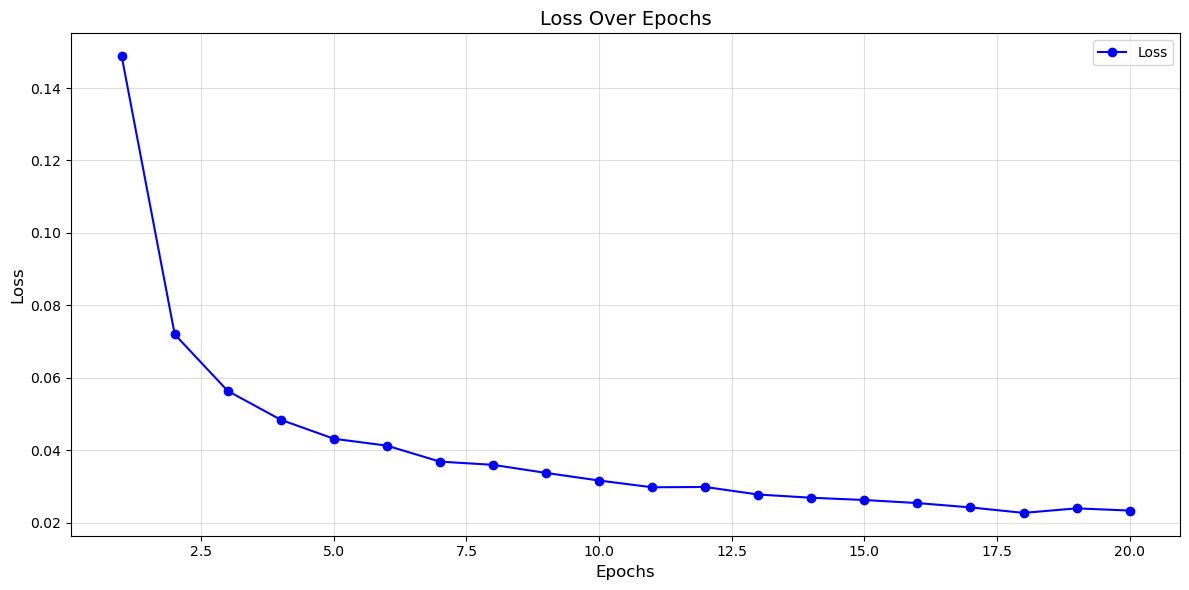

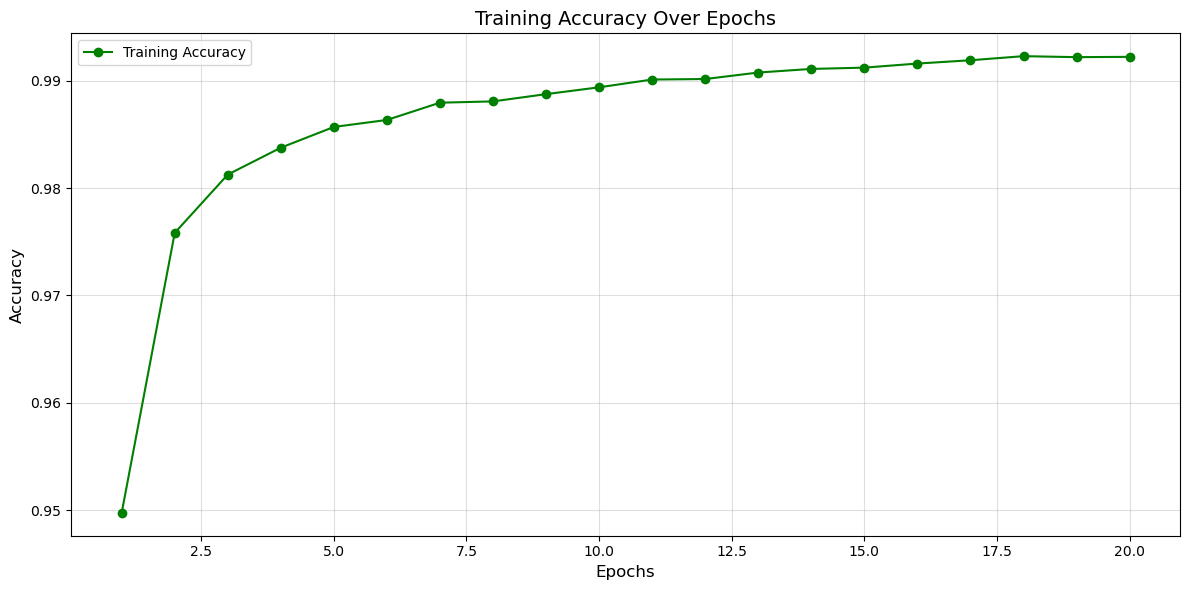

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score

# Define the GRU model (you should already have the model defined, so no need to redefine it here)
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(64, input_shape=(x_train_balanced.shape[1], x_train_balanced.shape[2]), return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # 5 classes for arrhythmias
])

gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Number of epochs
epochs = 20

# Initialize lists to store metrics
train_losses_2 = []
train_accuracies_2 = []

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Train for one epoch
    history = gru_model.fit(x_train_balanced, y_train_balanced, epochs=1, batch_size=32, verbose=0, validation_data=(x_test, y_test_encoded))

    # Get the loss and accuracy for the epoch
    train_loss = history.history['loss'][0]
    train_accuracy = history.history['accuracy'][0]

    # Store metrics
    train_losses_2.append(train_loss)
    train_accuracies_2.append(train_accuracy)

    print(f"Epoch {epoch + 1}: Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}")

# Plot Loss Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses_2, label='Loss', marker='o', color='blue')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Over Epochs', fontsize=14)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Plot Accuracy Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_accuracies_2, label='Training Accuracy', marker='o', color='green')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training Accuracy Over Epochs', fontsize=14)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [85]:
y_pred_probs = gru_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"GRU Accuracy: {accuracy * 100:.2f}%")

684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
GRU Accuracy: 97.71%


In [86]:
print(train_losses_2)
print(train_accuracies_2)

[0.14878958463668823, 0.07200867682695389, 0.056406162679195404, 0.048450976610183716, 0.04321490600705147, 0.04130982980132103, 0.03690203279256821, 0.036017414182424545, 0.03378511220216751, 0.0316888727247715, 0.029825177043676376, 0.029907753691077232, 0.027822384610772133, 0.02693835459649563, 0.02631307952105999, 0.025469766929745674, 0.024269184097647667, 0.022758042439818382, 0.024006668478250504, 0.023401865735650063]
[0.9497519731521606, 0.9758279919624329, 0.9812600016593933, 0.9837639927864075, 0.985696017742157, 0.9863479733467102, 0.9879559874534607, 0.9880759716033936, 0.988752007484436, 0.9893879890441895, 0.9901120066642761, 0.9901599884033203, 0.9907640218734741, 0.991100013256073, 0.9912199974060059, 0.991599977016449, 0.9919080138206482, 0.9922879934310913, 0.9921960234642029, 0.9922239780426025]


In [87]:
MODEL = 3

In [88]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from wfdb import rdsamp, rdann
import os

# Cell 1: Data Loading and Preprocessing
def load_and_preprocess_data(record_names, sequence_length=200):
    features = []
    labels = []
    
    for record in record_names:
        # Load signal data
        signal, fields = rdsamp(f'D:/endyrproj/arry_svn/Arrhythmia_Classification-main/mit-bih-arrhythmia-database-1.0.0/{record}')
        # Load annotations
        ann = rdann(f'D:/endyrproj/arry_svn/Arrhythmia_Classification-main/mit-bih-arrhythmia-database-1.0.0/{record}', 'atr')
        
        # Extract sequences for each beat
        for idx in range(len(ann.sample)-1):
            start = ann.sample[idx]
            end = ann.sample[idx+1]
            
            if end - start > sequence_length:
                # Extract fixed-length sequence
                beat = signal[start:start+sequence_length, 0]
                features.append(beat)
                labels.append(ann.symbol[idx])
    
    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)
    
    # Normalize features
    scaler = StandardScaler()
    features_reshaped = features.reshape(-1, features.shape[-1])
    features_scaled = scaler.fit_transform(features_reshaped)
    features = features_scaled.reshape(features.shape)
    
    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_onehot = to_categorical(labels_encoded)
    
    return features, labels_onehot, label_encoder

# Cell 2: Model Definition
def create_model(sequence_length, n_classes):
    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=(sequence_length, 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Cell 3: Training and Evaluation
def train_and_evaluate_model():
    # Load data
    record_names = [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234]
    sequence_length = 200
    X, y, label_encoder = load_and_preprocess_data(record_names, sequence_length)
    
    # Reshape for CNN input
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and train model
    model = create_model(sequence_length, y.shape[1])
    epochs = 20
    train_losses_3 = []
    train_accuracies_3 = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        # Train for one epoch
        history = model.fit(
            X_train,
            y_train,
            epochs=1,
            batch_size=32,
            verbose=0,
            validation_data=(X_test, y_test)
        )
        
        # Extract and store the loss and accuracy
        train_loss = history.history['loss'][0]
        train_accuracy = history.history['accuracy'][0]
        train_losses_3.append(train_loss)
        train_accuracies_3.append(train_accuracy)
        
        print(f"Epoch {epoch + 1}: Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}")
    
    # Final evaluation
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Convert back to original labels
    y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
    y_test_labels = label_encoder.inverse_transform(y_test_classes)
    
    # Return history and predictions for visualization
    return train_losses_3, train_accuracies_3, y_test_labels, y_pred_labels

# Cell 4: Visualization
def plot_metrics(train_losses_3, train_accuracies_3, y_test, y_pred, label_encoder):
    # Plot Loss Over Epochs
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(train_losses_3) + 1), train_losses_3, label='Training Loss', marker='o', color='blue')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Loss Over Epochs', fontsize=14)
    plt.grid(alpha=0.4)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Plot Accuracy Over Epochs
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(train_accuracies_3) + 1), train_accuracies_3, label='Training Accuracy', marker='o', color='green')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training Accuracy Over Epochs', fontsize=14)
    plt.grid(alpha=0.4)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_names = label_encoder.classes_
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# Cell 5: Main Execution
if __name__ == "__main__":
    train_losses_3, train_accuracies_3, y_test, y_pred = train_and_evaluate_model()
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    plot_metrics(train_losses_3, train_accuracies_3, y_test, y_pred, label_encoder)


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
Epoch 1: Loss = 0.4186, Accuracy = 0.9032
Epoch 2/20
Epoch 2: Loss = 0.2216, Accuracy = 0.9476
Epoch 3/20
Epoch 3: Loss = 0.1799, Accuracy = 0.9554
Epoch 4/20
Epoch 4: Loss = 0.1579, Accuracy = 0.9601
Epoch 5/20
Epoch 5: Loss = 0.1430, Accuracy = 0.9638
Epoch 6/20
Epoch 6: Loss = 0.1353, Accuracy = 0.9654
Epoch 7/20
Epoch 7: Loss = 0.1253, Accuracy = 0.9678
Epoch 8/20
Epoch 8: Loss = 0.1183, Accuracy = 0.9691
Epoch 9/20
Epoch 9: Loss = 0.1102, Accuracy = 0.9715
Epoch 10/20
Epoch 10: Loss = 0.1059, Accuracy = 0.9721
Epoch 11/20
Epoch 11: Loss = 0.0999, Accuracy = 0.9730
Epoch 12/20
Epoch 12: Loss = 0.0974, Accuracy = 0.9742
Epoch 13/20
Epoch 13: Loss = 0.0961, Accuracy = 0.9748
Epoch 14/20
Epoch 14: Loss = 0.0897, Accuracy = 0.9759
Epoch 15/20
Epoch 15: Loss = 0.0894, Accuracy = 0.9754
Epoch 16/20
Epoch 16: Loss = 0.0844, Accuracy = 0.9764
Epoch 17/20
Epoch 17: Loss = 0.0816, Accuracy = 0.9773
Epoch 18/20
Epoch 18: Loss = 0.0827, Accuracy = 0.9772
Epoch 19/20
Epoch 19: Loss =

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NameError: name 'label_encoder' is not defined

In [100]:
print(train_losses_3)
print(train_accuracies_3)

[0.41855117678642273, 0.22164642810821533, 0.17985156178474426, 0.15785396099090576, 0.14300638437271118, 0.13527639210224152, 0.12533311545848846, 0.11833655834197998, 0.11016669869422913, 0.10589313507080078, 0.09986422210931778, 0.09738669544458389, 0.09607178717851639, 0.08970153331756592, 0.08936809003353119, 0.08444444835186005, 0.0816313847899437, 0.08269838243722916, 0.07999605685472488, 0.07918395102024078]
[0.9032203555107117, 0.9475651979446411, 0.9554336667060852, 0.9600713849067688, 0.9637972116470337, 0.9653865098953247, 0.967783510684967, 0.9691383838653564, 0.9715223908424377, 0.9720825552940369, 0.9729944467544556, 0.9741538763046265, 0.9747922420501709, 0.9759255647659302, 0.97535240650177, 0.9763815402984619, 0.9773325324058533, 0.9772152900695801, 0.9774628281593323, 0.9773455858230591]


In [102]:
plot_metrics(train_losses_3, train_accuracies_3, y_test, y_pred, label_encoder)

NameError: name 'label_encoder' is not defined

In [104]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

# Encode string labels into numerical labels
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # Transform categories to numbers
y_pred_encoded = label_encoder.transform(y_pred)  # Transform using the same encoder

# Number of unique classes
n_classes = len(label_encoder.classes_)

# Calculate metrics
def calculate_metrics(y_test, y_pred, n_classes):
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn = np.diag(conf_matrix)  # True negatives for each class
    fp = conf_matrix.sum(axis=0) - tn  # False positives for each class
    fn = conf_matrix.sum(axis=1) - tn  # False negatives for each class
    tp = conf_matrix.sum() - (fp + fn + tn)  # True positives for each class

    # Overall metrics
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, average='macro')  # Same as recall
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Specificity for each class
    specificity = np.mean([tn[i] / (tn[i] + fp[i]) if (tn[i] + fp[i]) > 0 else 0 for i in range(n_classes)])

    return accuracy, sensitivity, specificity, f1

accuracy, sensitivity, specificity, f1 = calculate_metrics(y_test_encoded, y_pred_encoded, n_classes)
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")

# AUC-ROC Score (if y_pred contains probabilities, not strings)
# For categorical labels, this step may not apply unless using probabilities
# auc_roc = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr')
# print(f"AUC-ROC Score: {auc_roc:.4f}")

# Decode numerical labels back to strings for report (if needed)
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_encoded, target_names=label_encoder.classes_))


Accuracy: 0.9790
Sensitivity (Recall): 0.5704
Specificity: 0.7533
F1-Score: 0.6062

Classification Report:
              precision    recall  f1-score   support

           !       0.00      0.00      0.00         1
           "       0.92      0.99      0.95        89
           +       0.84      0.78      0.81        27
           /       0.99      0.99      0.99      1348
           A       0.97      0.65      0.78       399
           E       1.00      0.95      0.97        20
           F       0.82      0.55      0.66        49
           J       0.00      0.00      0.00        16
           L       0.98      0.99      0.99      1555
           N       0.98      1.00      0.99     12730
           Q       1.00      0.25      0.40         8
           R       0.97      0.99      0.98      1482
           V       0.97      0.96      0.96      1161
           a       0.80      0.52      0.63        23
           e       0.00      0.00      0.00         3
           f       0.98     

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\m

In [ ]:
MODEL = 4

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8982

Classification Report:
              precision    recall  f1-score   support

           !       0.68      0.87      0.77        79
           "       1.00      0.96      0.98        80
           +       0.66      0.66      0.66       252
           /       0.89      0.87      0.88      1421
           A       0.72      0.18      0.29       520
           E       1.00      0.33      0.50        21
           F       0.79      0.57      0.66       156
           J       0.00      0.00      0.00         8
           L       0.90      0.87      0.88      1608
           N       0.90      0.98      0.94     14994
           Q       0.00      0.00      0.00         5
           R       0.92      0.89      0.90      1422
           V       0.91      0.71      0.80      1466
           [       0.00      0.00      0.00         1
           ]       0.00      0.00      0.00         1
           a       0.00      0.00      0.00        35
           e       0.00      0.00      0

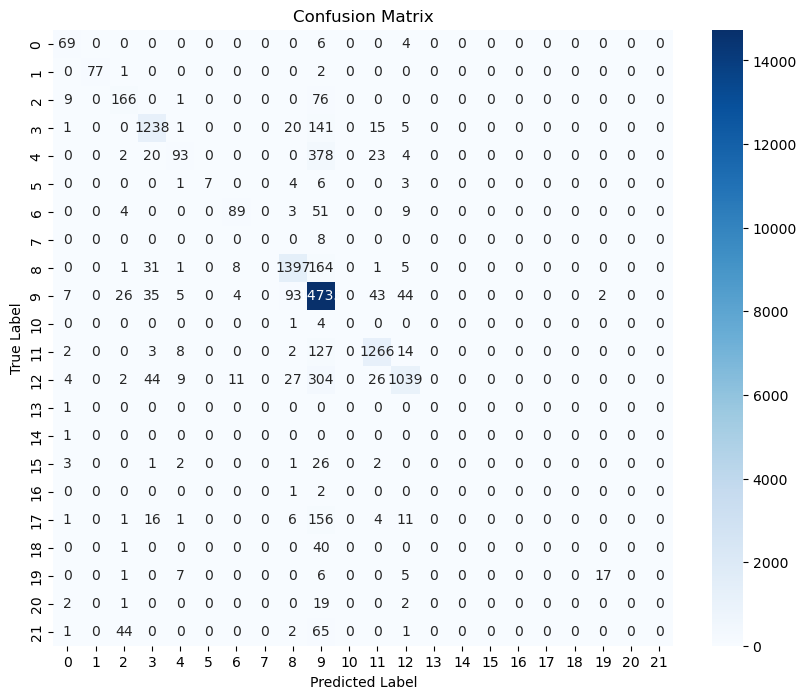

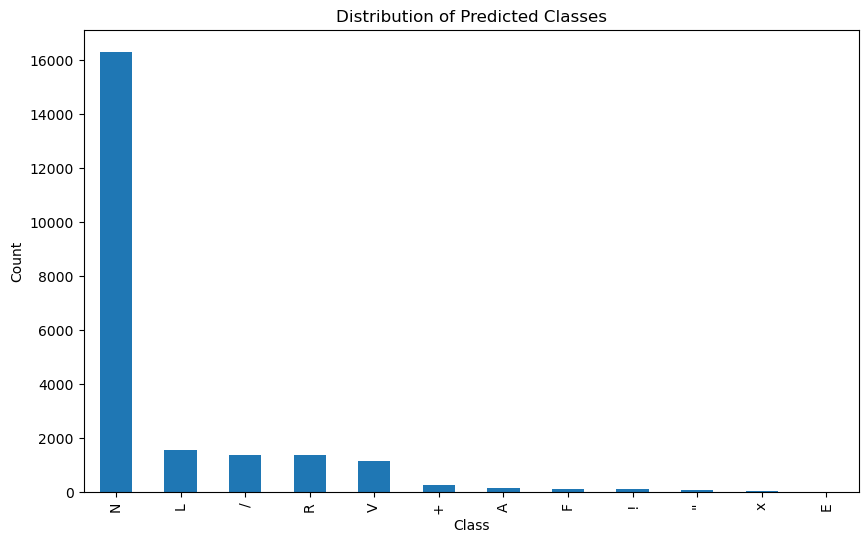

In [107]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wfdb import rdsamp, rdann
import os

# Cell 1: Data Loading and Preprocessing
def load_and_preprocess_data(record_names):
    features = []
    labels = []
    
    for record in record_names:
        # Load signal data
        signal, fields = rdsamp(f'D:/endyrproj/arry_svn/Arrhythmia_Classification-main/mit-bih-arrhythmia-database-1.0.0/{record}')
        # Load annotations
        ann = rdann(f'D:/endyrproj/arry_svn/Arrhythmia_Classification-main/mit-bih-arrhythmia-database-1.0.0/{record}', 'atr')
        
        # Extract features for each beat
        for idx in range(len(ann.sample)-1):
            start = ann.sample[idx]
            end = ann.sample[idx+1]
            
            if end - start > 50:  # Ensure minimum beat length
                # Extract RR intervals and signal features
                beat = signal[start:end, 0]  # Channel 1
                
                # Basic features
                features.append([
                    np.mean(beat),
                    np.std(beat),
                    np.max(beat),
                    np.min(beat),
                    end - start,  # RR interval
                    np.median(beat),
                    np.percentile(beat, 25),
                    np.percentile(beat, 75)
                ])
                labels.append(ann.symbol[idx])
    
    return np.array(features), np.array(labels)

# Cell 2: Model Training and Evaluation
def train_and_evaluate_model():
    # Load data
    record_names = [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234]
    X, y = load_and_preprocess_data(record_names)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train SVM model
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = svm.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    return accuracy, report, conf_matrix, y_test, y_pred

# Cell 3: Visualization
def plot_metrics(conf_matrix, y_test, y_pred):
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot distribution of predictions
    plt.figure(figsize=(10, 6))
    pd.Series(y_pred).value_counts().plot(kind='bar')
    plt.title('Distribution of Predicted Classes')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# Cell 4: Main Execution
if __name__ == "__main__":
    accuracy, report, conf_matrix, y_test, y_pred = train_and_evaluate_model()
    
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    plot_metrics(conf_matrix, y_test, y_pred)


In [108]:
from sklearn.metrics import roc_auc_score, roc_curve

# Cell 5: Calculate Additional Metrics
def calculate_metrics(conf_matrix, y_test, y_pred):
    # Sensitivity (Recall) for each class
    recall_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    sensitivity = recall_per_class.mean()
    
    # Specificity for each class
    specificity_per_class = []
    for i in range(len(conf_matrix)):
        tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
        fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
        specificity_per_class.append(tn / (tn + fp))
    specificity = np.mean(specificity_per_class)
    
    # F1-Score (from classification report)
    f1_scores = classification_report(y_test, y_pred, output_dict=True)
    f1_score_macro = f1_scores["macro avg"]["f1-score"]
    
    # AUC-ROC (one-vs-rest for multi-class)
    y_test_binary = pd.get_dummies(y_test)  # One-hot encoding
    y_pred_binary = pd.get_dummies(y_pred)
    roc_auc = roc_auc_score(y_test_binary, y_pred_binary, average="macro", multi_class="ovr")
    
    return sensitivity, specificity, f1_score_macro, roc_auc

# Cell 6: Print Metrics
if __name__ == "__main__":
    
    sensitivity, specificity, f1_score_macro, roc_auc = calculate_metrics(conf_matrix, y_test, y_pred)
    
    print(f"\nSensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1_score_macro:.4f}")
    print(f"AUC-ROC Value: {roc_auc:.4f}")




Sensitivity (Recall): 0.3805
Specificity: 0.9889
F1-Score: 0.4038
AUC-ROC Value: 0.6444


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
MODEL = 5

In [110]:
# MODEL BUILDING AND TRAINING - RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


Epoch 1/20
Epoch 1: Loss = 1.1449, Accuracy = 0.5419
Epoch 2/20
Epoch 2: Loss = 1.2659, Accuracy = 0.4663
Epoch 3/20
Epoch 3: Loss = 1.1832, Accuracy = 0.5147
Epoch 4/20
Epoch 4: Loss = 1.1297, Accuracy = 0.5427
Epoch 5/20
Epoch 5: Loss = 1.1857, Accuracy = 0.5120
Epoch 6/20
Epoch 6: Loss = 1.1847, Accuracy = 0.5040
Epoch 7/20
Epoch 7: Loss = 1.3111, Accuracy = 0.4369
Epoch 8/20
Epoch 8: Loss = 1.1345, Accuracy = 0.5344
Epoch 9/20
Epoch 9: Loss = 1.0135, Accuracy = 0.6067
Epoch 10/20
Epoch 10: Loss = 1.2708, Accuracy = 0.4727
Epoch 11/20
Epoch 11: Loss = 1.2248, Accuracy = 0.4931
Epoch 12/20
Epoch 12: Loss = 1.2641, Accuracy = 0.4691
Epoch 13/20
Epoch 13: Loss = 1.2589, Accuracy = 0.4907
Epoch 14/20
Epoch 14: Loss = 1.3541, Accuracy = 0.4287
Epoch 15/20
Epoch 15: Loss = 1.3647, Accuracy = 0.4128
Epoch 16/20
Epoch 16: Loss = 1.3381, Accuracy = 0.4194
Epoch 17/20
Epoch 17: Loss = 1.3476, Accuracy = 0.4158
Epoch 18/20
Epoch 18: Loss = 1.3485, Accuracy = 0.4351
Epoch 19/20
Epoch 19: Loss =

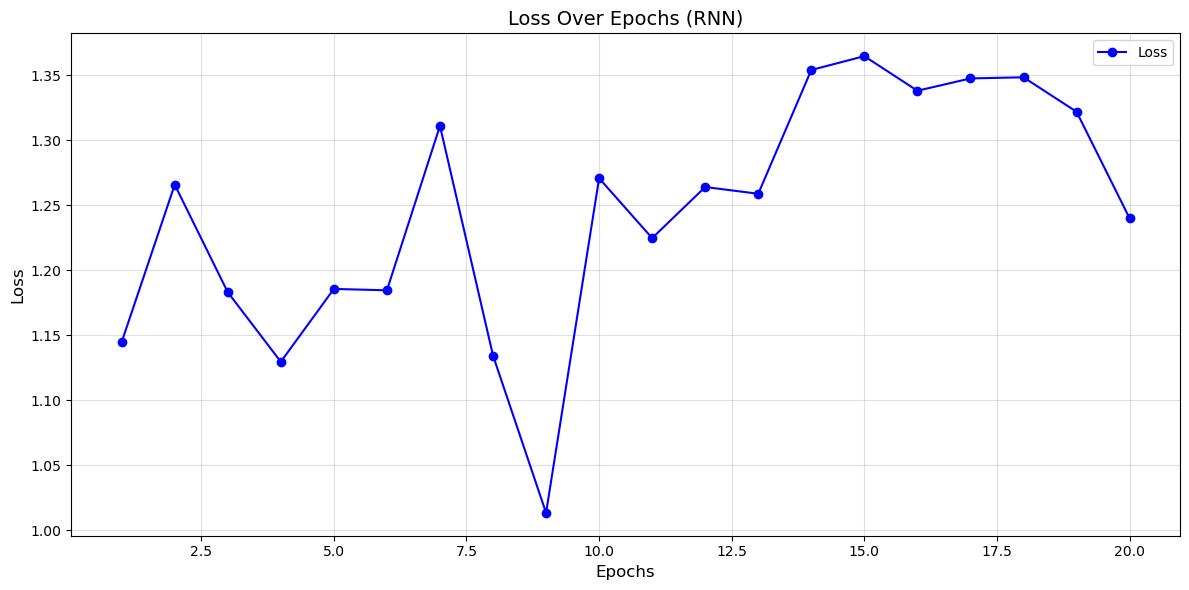

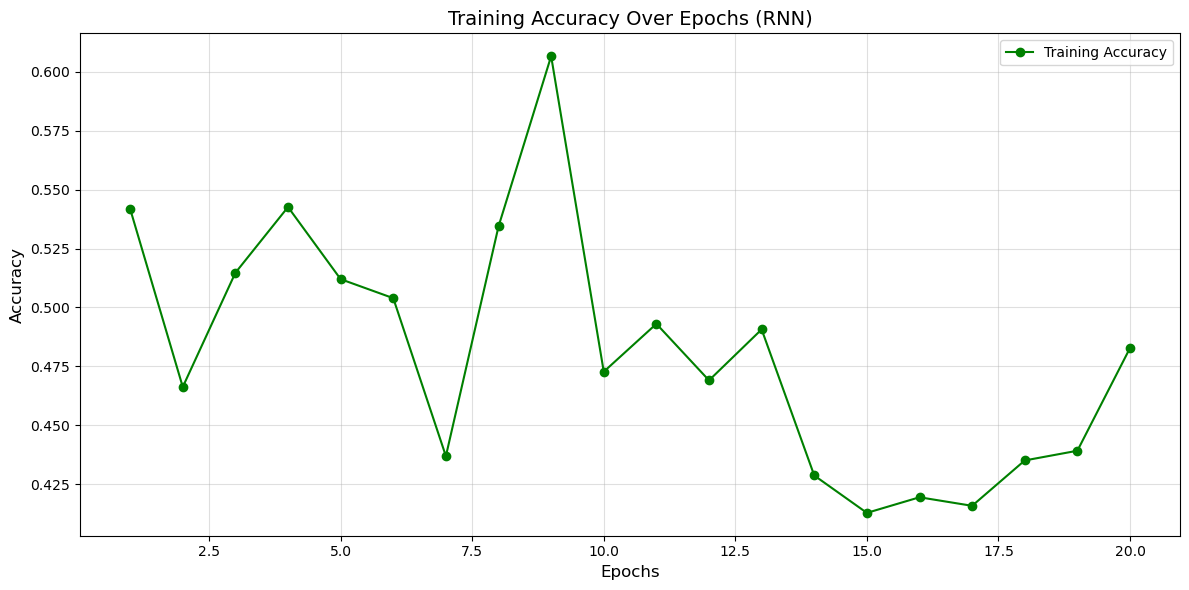

In [116]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Prepare the features and labels
X_train = train_data_r.iloc[:, :-1].to_numpy().reshape(-1, 300, 1)  # Reshape for RNN input
y_train = tf.keras.utils.to_categorical(train_data_r.iloc[:, -1].to_numpy(), num_classes=5)

X_test = test_data.iloc[:, :-1].to_numpy().reshape(-1, 300, 1)
y_test = tf.keras.utils.to_categorical(test_data.iloc[:, -1].to_numpy(), num_classes=5)

# Define the RNN model
model = Sequential([
    SimpleRNN(32, input_shape=(300, 1), return_sequences=True, activation='tanh'),
    Dropout(0.2),
    SimpleRNN(16, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Initialize lists to store training metrics
epochs = 20
train_losses_4 = []
train_accuracies_4 = []

# Training loop with manual logging of loss and accuracy
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    # Train for one epoch
    history = model.fit(
        X_train,
        y_train,
        epochs=1,
        batch_size=64,  # Increased batch size
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )
    
    # Extract and store the loss and accuracy
    train_loss = history.history['loss'][0]
    train_accuracy = history.history['accuracy'][0]
    train_losses_4.append(train_loss)
    train_accuracies_4.append(train_accuracy)
    
    print(f"Epoch {epoch + 1}: Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}")

# Plot Loss Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses_4, label='Loss', marker='o', color='blue')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Over Epochs (RNN)', fontsize=14)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Plot Accuracy Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_accuracies_4, label='Training Accuracy', marker='o', color='green')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training Accuracy Over Epochs (RNN)', fontsize=14)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [118]:
print(train_losses_4)
print(train_accuracies_4)

[1.1448893547058105, 1.265896201133728, 1.183169960975647, 1.129708170890808, 1.1857260465621948, 1.1846650838851929, 1.3111339807510376, 1.134522557258606, 1.0135095119476318, 1.2708361148834229, 1.2248022556304932, 1.2640950679779053, 1.2589040994644165, 1.3540977239608765, 1.3647104501724243, 1.33812415599823, 1.3475987911224365, 1.3484597206115723, 1.3219703435897827, 1.2400301694869995]
[0.5418639779090881, 0.466264009475708, 0.514739990234375, 0.5426599979400635, 0.5120279788970947, 0.5039600133895874, 0.43688398599624634, 0.5344039797782898, 0.606719970703125, 0.4727320075035095, 0.4930639863014221, 0.4690600037574768, 0.4907039999961853, 0.4286639988422394, 0.4127880036830902, 0.4194200038909912, 0.41579198837280273, 0.43505600094795227, 0.4391759932041168, 0.48278799653053284]


In [120]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix

# Get model predictions on the test data
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = y_pred_prob.argmax(axis=1)  # Predicted class labels
y_true = y_test.argmax(axis=1)       # True class labels

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # Weighted for multi-class
recall = recall_score(y_true, y_pred, average='weighted')        # Sensitivity
f1 = f1_score(y_true, y_pred, average='weighted')
auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')  # One-vs-Rest AUC-ROC

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: N/A (not defined for multi-class directly)")  # Specificity needs per-class confusion matrix
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")


684/684 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step
Accuracy: 0.4183
Precision: 0.7794
Recall (Sensitivity): 0.4183
Specificity: N/A (not defined for multi-class directly)
F1-Score: 0.4973
AUC-ROC Score: 0.7264


In [122]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Get predictions and true labels
y_pred = model.predict(X_test).argmax(axis=1)  # Predicted class labels
y_true = y_test.argmax(axis=1)                # True class labels

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate specificity for each class
specificities = []
for i in range(conf_matrix.shape[0]):  # Loop through each class
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))  # True Negatives
    fp = np.sum(np.delete(conf_matrix[:, i], i))  # False Positives
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificities.append(specificity)

# Calculate total specificity as the average
total_specificity = np.mean(specificities)

# Print total specificity
print(f"Total Specificity: {total_specificity:.4f}")


684/684 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step
Total Specificity: 0.8463


In [ ]:
MODEL = 6

In [124]:
# MODEL BUILDING AND TRAINING
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib  # For saving the trained model

In [126]:
# Load the balanced training data
train_data_path = project_path + 'train_data_SMOTE.pkl'
test_data_path = project_path + 'test_data.pkl'

train_data_r = pd.read_pickle(train_data_path)
test_data = pd.read_pickle(test_data_path)


In [128]:
# Separate features (X) and labels (y)
X_train = train_data_r.iloc[:, :-1].to_numpy()
y_train = train_data_r.iloc[:, -1].to_numpy()

X_test = test_data.iloc[:, :-1].to_numpy()
y_test = test_data.iloc[:, -1].to_numpy()


In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss

# Initialize lists to store accuracy and loss
train_accuracies_5 = []
train_losses_5 = []

# Iterate over a range of tree counts (simulating epochs)
for n_estimators in range(5, 105, 5):  # From 5 to 100 trees, step by 5
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=42,
        class_weight="balanced",
        max_depth=10
    )
    
    # Fit the model
    rf_model.fit(X_train, y_train)
    
    # Predict on training set
    y_pred_proba = rf_model.predict_proba(X_train)
    y_pred = rf_model.predict(X_train)
    
    # Calculate metrics
    accuracy = accuracy_score(y_train, y_pred)
    loss = log_loss(y_train, y_pred_proba)
    
    # Store results
    train_accuracies_5.append(accuracy)
    train_losses_5.append(loss)
    
    print(f"Trees: {n_estimators}, Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

# Now `train_accuracies` and `train_losses` have the simulated training progress


Trees: 5, Accuracy: 0.9220, Loss: 0.2817
Trees: 10, Accuracy: 0.9334, Loss: 0.2683
Trees: 15, Accuracy: 0.9342, Loss: 0.2655
Trees: 20, Accuracy: 0.9338, Loss: 0.2693
Trees: 25, Accuracy: 0.9345, Loss: 0.2683
Trees: 30, Accuracy: 0.9374, Loss: 0.2622
Trees: 35, Accuracy: 0.9372, Loss: 0.2613
Trees: 40, Accuracy: 0.9374, Loss: 0.2626
Trees: 45, Accuracy: 0.9377, Loss: 0.2634
Trees: 50, Accuracy: 0.9379, Loss: 0.2629
Trees: 55, Accuracy: 0.9378, Loss: 0.2619
Trees: 60, Accuracy: 0.9379, Loss: 0.2621
Trees: 65, Accuracy: 0.9395, Loss: 0.2604
Trees: 70, Accuracy: 0.9408, Loss: 0.2586
Trees: 75, Accuracy: 0.9397, Loss: 0.2609
Trees: 80, Accuracy: 0.9392, Loss: 0.2621
Trees: 85, Accuracy: 0.9381, Loss: 0.2633
Trees: 90, Accuracy: 0.9385, Loss: 0.2638
Trees: 95, Accuracy: 0.9387, Loss: 0.2636
Trees: 100, Accuracy: 0.9386, Loss: 0.2633


In [133]:
print(train_accuracies_5)
print(train_losses_5)

[0.922036, 0.933372, 0.934248, 0.9338, 0.934548, 0.937436, 0.937244, 0.937412, 0.937732, 0.937908, 0.937784, 0.937872, 0.939476, 0.940776, 0.939736, 0.939224, 0.938128, 0.93852, 0.938712, 0.938576]
[0.28170702572103173, 0.2682897313365634, 0.26553924025999387, 0.2692522748300807, 0.2683229381515832, 0.26224909559317294, 0.26128089037323604, 0.26258238514786864, 0.2633626300087603, 0.2628886475525811, 0.26186480355941716, 0.26208538989936586, 0.26042096680500626, 0.2586163186462855, 0.26087766636482357, 0.2621051306043934, 0.2633422968003297, 0.2638200199472451, 0.26364201487199423, 0.26331292115350935]


In [145]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

# Use y_test directly if it is already in label format
y_test_labels = y_test  # Assuming y_test is a 1D array of labels
y_pred_labels = y_pred.argmax(axis=1) if len(y_pred.shape) > 1 else y_pred  # Ensure correct format for predictions

# Accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)

# Sensitivity (Recall)
recall = recall_score(y_test_labels, y_pred_labels, average='macro')  # Average='macro' for multi-class

# Confusion Matrix for Specificity
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
specificity = []
for i in range(len(conf_matrix)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))
specificity = sum(specificity) / len(specificity)  # Average specificity for all classes

# F1-Score
f1 = f1_score(y_test_labels, y_pred_labels, average='macro')  # Average='macro' for multi-class

# Precision
precision = precision_score(y_test_labels, y_pred_labels, average='macro')  # Average='macro' for multi-class

# AUC-ROC
if len(rf_model.classes_) > 2:
    auc_roc = roc_auc_score(
        tf.keras.utils.to_categorical(y_test_labels, num_classes=len(rf_model.classes_)),
        rf_model.predict_proba(X_test),
        multi_class='ovr',
        average='macro'
    )
else:
    auc_roc = roc_auc_score(y_test_labels, y_pred_proba)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")


Accuracy: 0.9401
Sensitivity (Recall): 0.8921
Specificity: 0.9775
F1-Score: 0.7734
AUC-ROC: 0.9836
Precision: 0.7245


In [ ]:
MODEL =7

Epoch 1/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 212s 209ms/step - accuracy: 0.5956 - loss: 0.9748 - val_accuracy: 0.8626 - val_loss: 0.5686
Epoch 2/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 215s 220ms/step - accuracy: 0.8558 - loss: 0.3845 - val_accuracy: 0.8608 - val_loss: 0.3995
Epoch 3/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 234s 239ms/step - accuracy: 0.8986 - loss: 0.2793 - val_accuracy: 0.8885 - val_loss: 0.3411
Epoch 4/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 239s 244ms/step - accuracy: 0.9217 - loss: 0.2242 - val_accuracy: 0.9069 - val_loss: 0.2805
Epoch 5/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 233s 239ms/step - accuracy: 0.9370 - loss: 0.1870 - val_accuracy: 0.9183 - val_loss: 0.2445
Epoch 6/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 220s 225ms/step - accuracy: 0.9477 - loss: 0.1579 - val_accuracy: 0.9286 - val_loss: 0.2278
Epoch 7/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 227s 232ms/step - accuracy: 0.9532 - loss: 0.1422 - val_accuracy: 0.9456 - val_loss: 0.1759
Epoch 8/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 223s 228ms/step - accuracy: 0.9571 -

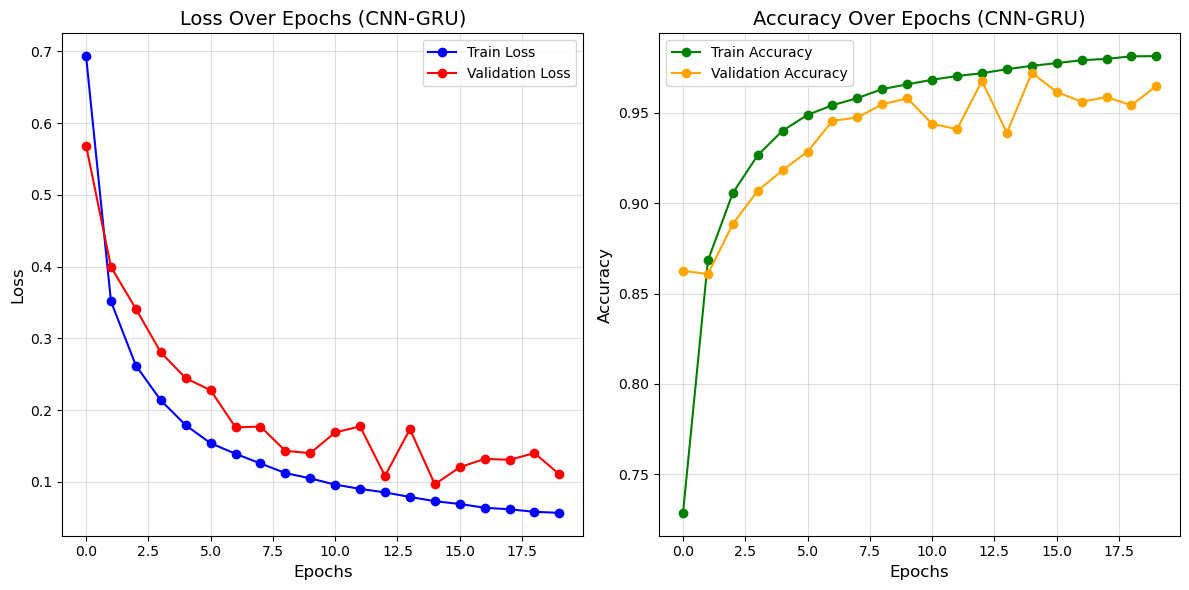

In [155]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# Prepare the features and labels (assuming preprocessed train_data and test_data)
X_train = train_data_r.iloc[:, :-1].to_numpy().reshape(-1, 300, 1)  # Reshape for CNN-GRU input
y_train = tf.keras.utils.to_categorical(train_data_r.iloc[:, -1].to_numpy(), num_classes=5)

X_test = test_data.iloc[:, :-1].to_numpy().reshape(-1, 300, 1)
y_test = tf.keras.utils.to_categorical(test_data.iloc[:, -1].to_numpy(), num_classes=5)

# Define the Hybrid CNN-GRU model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(300, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    GRU(64, return_sequences=True, activation='tanh'),
    Dropout(0.2),

    GRU(32, activation='tanh'),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # 5 classes for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Metrics
accuracy = tf.keras.metrics.Accuracy()(y_true, y_pred).numpy()
classification_metrics = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(5)])
auc_roc = roc_auc_score(y_test, model.predict(X_test), multi_class='ovr')

# Confusion Matrix for Specificity
conf_matrix = confusion_matrix(y_true, y_pred)
specificity = []
for i in range(len(conf_matrix)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))
specificity = sum(specificity) / len(specificity)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_metrics)
print(f"Specificity: {specificity:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Plot Loss and Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='red')
plt.title('Loss Over Epochs (CNN-GRU)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.4)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', color='orange')
plt.title('Accuracy Over Epochs (CNN-GRU)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.4)

plt.tight_layout()
plt.show()


In [158]:
# Lists to store training accuracy and loss
training_accuracy_6 = history.history['accuracy']
training_loss_6 = history.history['loss']


# Print or inspect the saved values
print("Training Accuracy per Epoch:", training_accuracy_6)
print("Training Loss per Epoch:", training_loss_6)


Training Accuracy per Epoch: [0.728663980960846, 0.8683159947395325, 0.9056599736213684, 0.9265639781951904, 0.940123975276947, 0.9488760232925415, 0.9542120099067688, 0.9581519961357117, 0.9631239771842957, 0.9657599925994873, 0.968288004398346, 0.9703879952430725, 0.9719120264053345, 0.9741320013999939, 0.9760040044784546, 0.9774960279464722, 0.9791039824485779, 0.9798640012741089, 0.9812600016593933, 0.9813479781150818]
Training Loss per Epoch: [0.6932276487350464, 0.3514583706855774, 0.2621152102947235, 0.213726207613945, 0.17899492383003235, 0.15392258763313293, 0.13922566175460815, 0.12570008635520935, 0.11237394064664841, 0.10492122918367386, 0.09623057395219803, 0.09030167758464813, 0.08533963561058044, 0.07904238253831863, 0.07313830405473709, 0.06923767179250717, 0.06401797384023666, 0.06180613487958908, 0.05836976319551468, 0.0568392314016819]


In [165]:
# Calculate Metrics
accuracy = tf.keras.metrics.Accuracy()(y_true, y_pred).numpy()
classification_metrics = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(5)], output_dict=True)

# Extract key metrics for each class and compute averages
precision = classification_metrics['weighted avg']['precision']
recall = classification_metrics['weighted avg']['recall']  # Sensitivity
f1_score = classification_metrics['weighted avg']['f1-score']

# AUC-ROC score (multi-class, OVR)
auc_roc = roc_auc_score(y_test, model.predict(X_test), multi_class='ovr')

# Confusion Matrix for Specificity
conf_matrix = confusion_matrix(y_true, y_pred)
specificity_list = []
for i in range(len(conf_matrix)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity_list.append(tn / (tn + fp))
specificity = sum(specificity_list) / len(specificity_list)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")


684/684 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step
Accuracy: 0.9721
Precision: 0.9781
Recall (Sensitivity): 0.9721
Specificity: 0.9909
F1-Score: 0.9741
AUC-ROC Score: 0.9951


In [ ]:
MODEL = 8

In [187]:
# Read ECG signals and corresponding label
def getDataSet(number, X_data, Y_data):
    
    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q'] 

    # Reading Channel names
    _, info = wfdb.io.rdsamp(osj(project_path, number))
    channels = info['sig_name']
    channel1, channel2 = channels[0], channels[1]
    print(channel1, channel2)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record = wfdb.rdrecord(project_path + number, channel_names=[channel1])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation = wfdb.rdann(project_path + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3  
    i = start
    j = len(annotation.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type = Rclass[i]
            lable = ecgClassSet.index(beat_type)  # when beat is like '+' or other it will go on except loop
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [189]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
                 '222', '223', '228', '230', '231', '232', '233', '234'] # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # dataset and its label set
    X = train_ds[:, :300]
    Y = train_ds[:, 300]
    return X, Y

In [191]:
# Input X and Output Y data loading
X, Y = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [193]:
from collections import Counter
# Counting the number of each type of heartbeats
Y_list = list(Y)
Counter(Y_list)

Counter({0.0: 74920,
         1.0: 8063,
         2.0: 7244,
         9.0: 7123,
         12.0: 7012,
         5.0: 2540,
         13.0: 982,
         11.0: 802,
         4.0: 229,
         6.0: 150,
         10.0: 106,
         7.0: 83,
         14.0: 33,
         3.0: 16,
         8.0: 2})

In [195]:
# making pandas dataframe
df_X = pd.DataFrame(X)
df_Y = pd.DataFrame(Y)

In [197]:
# changing the name from 0 to 300
df_Y.rename(columns = {0:300}, inplace = True)
# join X and Y
df = pd.concat([df_X, df_Y], axis=1)

In [199]:
def Plot_Random_Beat(type, num):

  ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', 'slash', 'f', 'Q']
  
  ecgClassName = ['Normal (N)', 'Left bundle br. bl. (L)', 'Right bundle br. bl. (R)', 
                  'Atrial escape (e)', 'Nodal jun. esc. (j)', 'Atrial premature (A)', 
                  'Aberrated atrial prem. (a)', 'Nodal jun. pre. (J)', 
                  'Supraventricular prem. (S)', 'Premature ventr. (V)', 
                  'Ventricular escape (E)', 'Fusion of ve. & no. (F)', 
                  'Paced (/)', 'Fusion of pa. & no. (f)', 
                  'Unclassifiable(Q)'] 

  # getting only a specific class ECG signal
  df_0 = df.loc[df[300]==type]  # For normanl class: 0, shape is 74920,301
  df_0 = df_0.drop(columns=[300]) # changing the shape to 74920,300

  # selecting some random row to plot
  if num<=df_0.shape[0]:
    np.random.seed(234)
    random_beat_number = np.random.randint(df_0.shape[0], size=(num))
    random_beat_number = list(random_beat_number)
  else: # Needed for Supraventricular Premature Beat (S) only, as it contains only 2 beats
    print(f"Warning: You have only {df_0.shape[0]} beat, but asked to plot {num}")
    random_beat_number = np.arange(0, df_0.shape[0])
    random_beat_number = list(random_beat_number)
  
  # ploting the ECG signal
  for i in random_beat_number:
    ecg_beat = df_0.iloc[i]
    plt.plot(ecg_beat)
  plt.title(str(ecgClassName[type]))

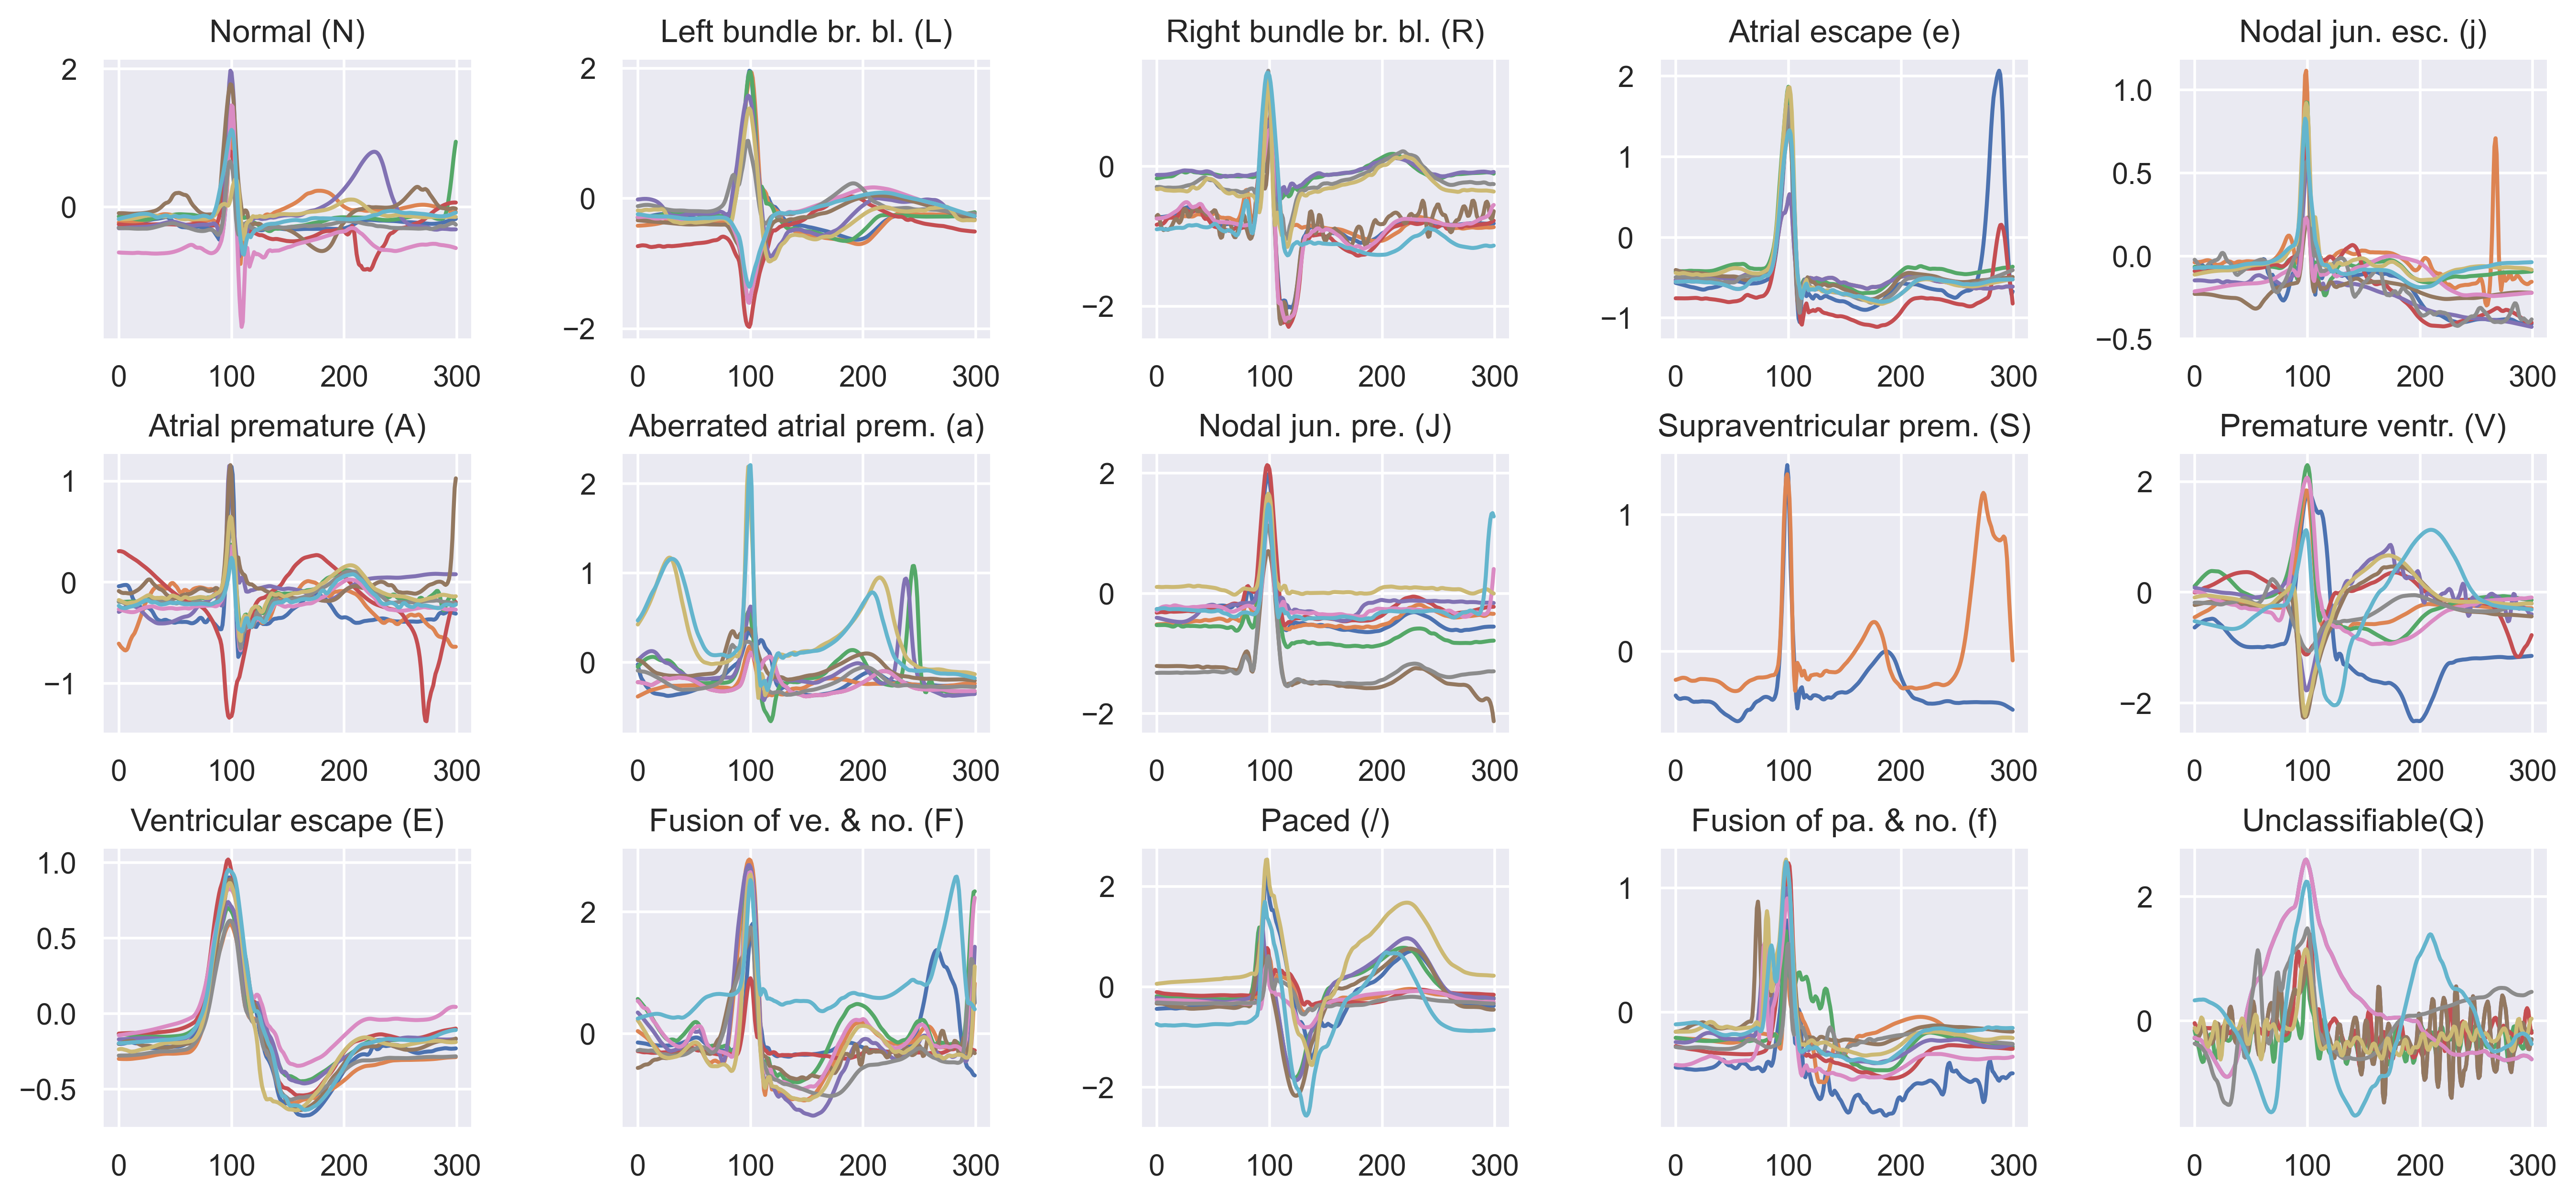

In [201]:
# Plotting 15 different types of heartbeat
fig = plt.figure(figsize=(16,7), dpi=400)
fig.tight_layout(pad=15.0)
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
  Plot_Random_Beat(type=i, num=10)
figure_path = r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\heartbeat_figures\\'
fig.savefig(figure_path+ 'all_heartbeats.png')

In [203]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
                 '222', '223', '228', '230', '231', '232', '233', '234']  # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)
    return train_ds

In [205]:
# Load the whole dataset (109305,301). Each row indicate an ECG beat time series data upto 300 
# and 301 colum is its label among 15 difference level
train_ds = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [207]:
Y = train_ds[:, 300]

In [209]:
# Here 15 class of ECG data are saved 
Y_list = list(Y)
Counter(Y_list)

Counter({0.0: 74920,
         1.0: 8063,
         2.0: 7244,
         9.0: 7123,
         12.0: 7012,
         5.0: 2540,
         13.0: 982,
         11.0: 802,
         4.0: 229,
         6.0: 150,
         10.0: 106,
         7.0: 83,
         14.0: 33,
         3.0: 16,
         8.0: 2})

In [211]:
# 15 level to 5 level conversion
Y_5class = np.copy(Y)

for i in range(Y.shape[0]):
  # print(i)
  if 0 <= Y[i] <= 4:
    Y_5class[i] = 0
  if 5 <= Y[i] <= 8:
    Y_5class[i] = 1
  if 9 <= Y[i] <= 10:
    Y_5class[i] = 2
  if Y[i] == 11:
    Y_5class[i] = 3
  if 12 <= Y[i] <= 14:
    Y_5class[i] = 4
print('changing done')

changing done


In [213]:
Y_5class_list = list(Y_5class)
Counter(Y_5class_list)

Counter({0.0: 90472, 4.0: 8027, 2.0: 7229, 1.0: 2775, 3.0: 802})

In [215]:
ecg_dataset = np.copy(train_ds)

In [217]:
# label encode the target variable # just convert numpy.float64 to numpy.int64
from sklearn.preprocessing import LabelEncoder
Y_5class = LabelEncoder().fit_transform(Y_5class)

In [219]:
ecg_data = ecg_dataset[:, :300]
ecg_lable = Y_5class.reshape(-1, 1) # otherwise np.hstack will not work 

In [221]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_5 = np.hstack((ecg_data, ecg_lable))

In [223]:
# Convert ndarray to dataframe
df_ecg = pd.DataFrame(ecg_dataset_5)
class_data = df_ecg[300].value_counts()
class_data

300
0.0    90472
4.0     8027
2.0     7229
1.0     2775
3.0      802
Name: count, dtype: int64

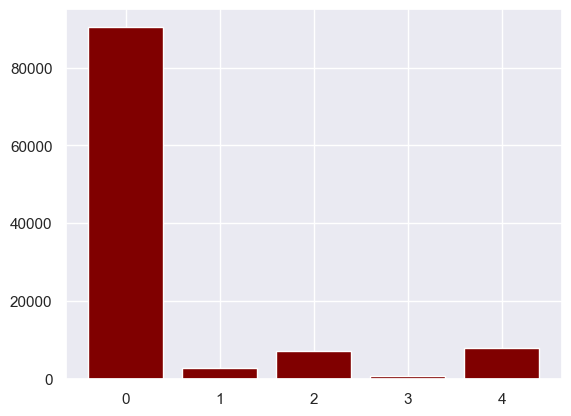

In [225]:
# per class data status plotting,
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

<Axes: xlabel='300'>

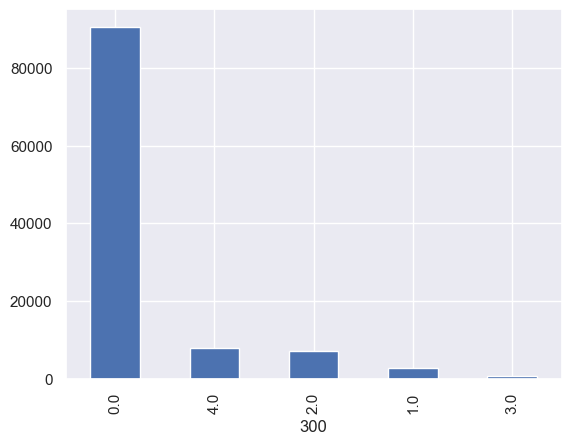

In [227]:
# shortcut for per class data status plotting,
# Order is not maintained by class. Higher to lower
df_ecg[300].value_counts().plot(kind='bar')

In [229]:
# train test splitting
from sklearn.model_selection import train_test_split
ecg_data = ecg_dataset_5[:, :300]
ecg_label = ecg_dataset_5[:, 300]
x_train, x_test, y_train, y_test = train_test_split(ecg_data, ecg_label,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

In [231]:
# reshaping for using hstack function
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
train_data = np.hstack((x_train, y_train))
test_data = np.hstack((x_test, y_test))

In [233]:
#  converting dataframe
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

300
0.0    72396
4.0     6421
2.0     5773
1.0     2223
3.0      631
Name: count, dtype: int64


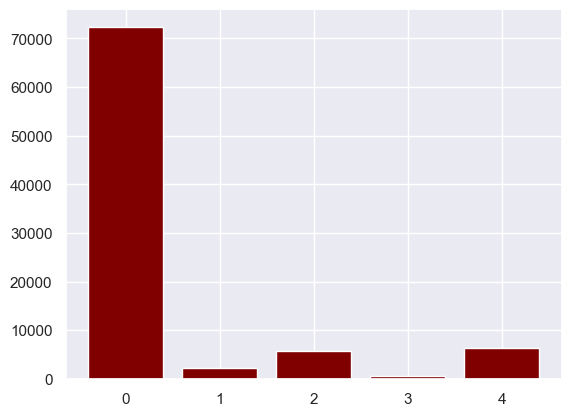

In [235]:
# Imblanced training data graph ploting 
class_data = train_data[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

In [237]:
# extracting class 0 and 4 others class
train_data_0 = train_data.loc[(train_data[300] == 0)]
train_data_1234 = train_data.loc[(train_data[300] != 0)]

In [239]:
# 1. Class 1: Randomly selected 50000 data
from sklearn.utils import resample
train_data_0_resampled=train_data_0.sample(n=50000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled = train_data_0_resampled.to_numpy()

In [241]:
# 2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

# converting from df to np ndarray
train_data_1234_arr = train_data_1234.to_numpy()
X_4cl, y_4cl = train_data_1234_arr[:, :-1], train_data_1234_arr[:, -1]

from imblearn.over_sampling import SMOTE
# transform the dataset
strategy = {1:50000, 2:50000, 3:50000, 4:50000}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X_4cl, y_4cl)

y = y.reshape(-1, 1)
train_data_1234_resampled = np.hstack((X, y))

In [243]:
# Join the class 0 and 1234
train_data_resampled = np.vstack((train_data_0_resampled, train_data_1234_resampled))

# shuffle the data, needed for proper training
np.take(train_data_resampled,np.random.permutation(train_data_resampled.shape[0]),axis=0,out=train_data_resampled)

array([[-0.28722445, -0.28848494, -0.28968116, ..., -0.2676001 ,
        -0.27120236,  0.        ],
       [-0.30751179, -0.3057489 , -0.30397116, ...,  0.75158413,
         0.82591842,  0.        ],
       [-0.16800687, -0.17244045, -0.17732933, ..., -0.28988055,
        -0.28821461,  1.        ],
       ...,
       [-0.07768788, -0.0759095 , -0.07457754, ..., -0.13804258,
        -0.13573806,  0.        ],
       [-0.65170895, -0.66662218, -0.68198135, ..., -0.11181153,
        -0.0988044 ,  2.        ],
       [ 0.0824179 ,  0.05861659,  0.0314233 , ...,  1.74909868,
         1.61083942,  2.        ]])

300
0.0    50000
1.0    50000
2.0    50000
3.0    50000
4.0    50000
Name: count, dtype: int64


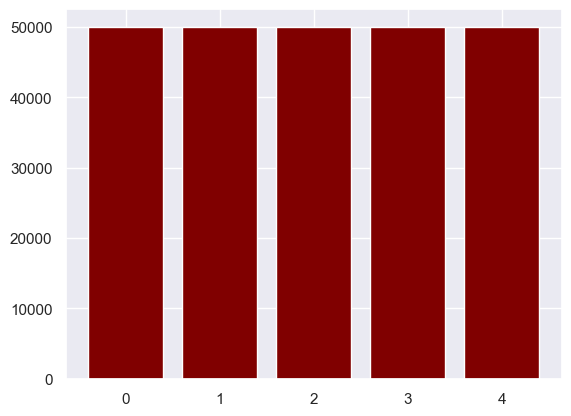

In [245]:
# blanced training data graph ploting 
train_data_r = pd.DataFrame(train_data_resampled)
class_data = train_data_r[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

# save balanced training data
file_name = project_path + 'train_data_SMOTE.pkl'
train_data_r.to_pickle(file_name)

In [247]:
data_bal = np.array(class_data)
data_bal2 = data_bal.reshape(1, 5)

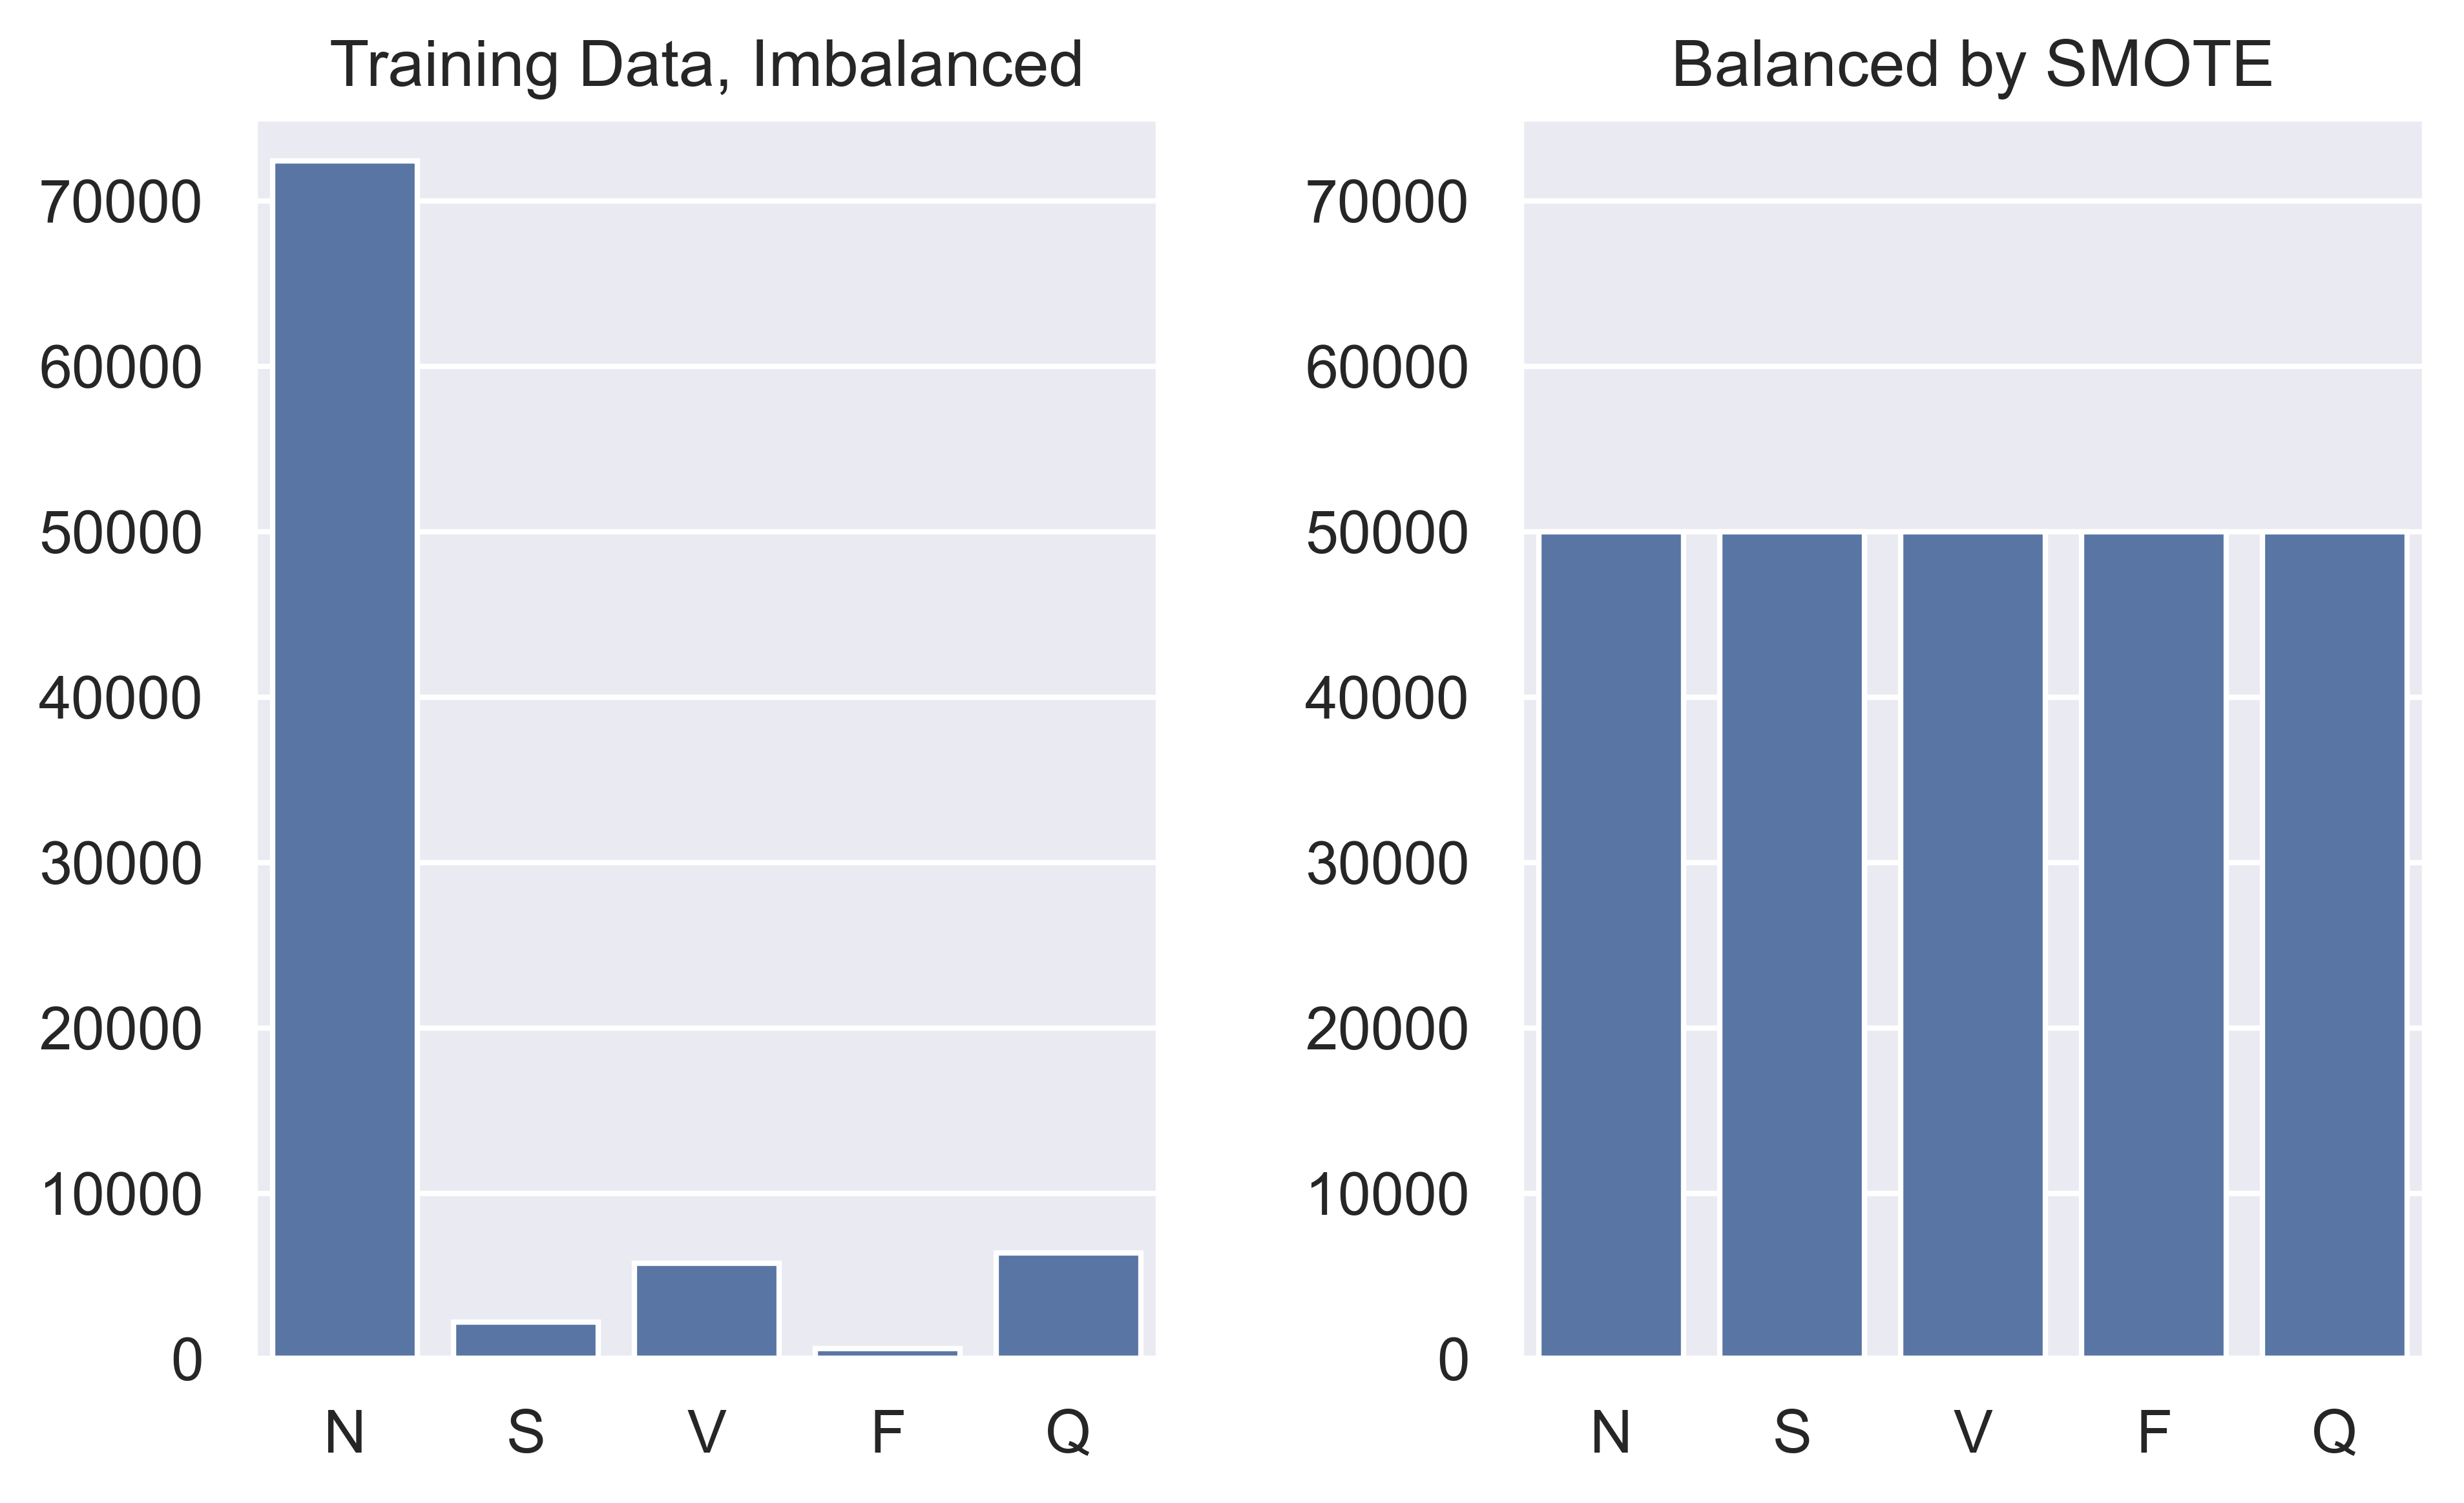

In [249]:
# a single plot which gives proper illustration before and after class balancing
import seaborn as sns
sns.set()
sns.color_palette("hls", 8)

fig = plt.figure(figsize=(7,4), dpi=600)
plt.subplot(121)
sns.barplot(x = ['N', 'S', 'V', 'F', 'Q'], y = [72420, 2212, 5774, 637, 6401])
plt.ylim(0, 75000)
plt.title('Training Data, Imbalanced')

plt.subplot(122)
sns.barplot(x = ['N', 'S', 'V', 'F', 'Q'], y = class_data.values)
plt.ylim(0, 75000)
plt.title('Balanced by SMOTE')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)

figure_path = r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\heartbeat_figures\\'
fig.savefig(figure_path+ 'Class balancing.png')

In [250]:
# udf for channel attention mechanism
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling1D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling1D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])

In [253]:
# udf for spatial attention mechanism
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention]) 

In [255]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # The first convolutional layer, sixteen 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(16, 8),
        # SpatialAttention(7),
        # The first pooling layer, max pooling, 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # The second convolution layer, 32 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(32, 8),
        # SpatialAttention(7),
        # The second pooling layer, max pooling, 3x1 convolution kernels, with a stride of 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # The third convolution layer, 64 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(64, 8),
        # SpatialAttention(7),
        # The third pooling layer, average pooling, 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),
        # The fourth convolution layer, 128 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(128, 8),
        SpatialAttention(7),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(64, return_sequences=True),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # LSTM layer, 32 nodes
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Flatten the layer to facilitate the processing of the fully connected layer
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

In [257]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # The first convolutional layer, four 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='same', activation='relu'),
        # The first pooling layer, max pooling, four 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
        # The second convolution layer, 16 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='same', activation='relu'),
        # The second pooling layer, max pooling, four 3x1 convolution kernels, with a stride of 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
        # The third convolution layer, 32 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='same', activation='relu'),
        # The third pooling layer, average pooling, four 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='same'),
        # The fourth convolution layer, 64 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='same', activation='relu'),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(128, return_sequences=True),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(64, return_sequences=True),
        # Flatten the layer to facilitate the processing of the fully connected layer
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

In [259]:
#Define the log directory, which must be a subdirectory of the specified 
#directory when starting the web application. It is recommended to use date and time as the subdirectory name
logdir = project_path + "logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = project_path + "ecg_model_code 17_t5.h5"

In [261]:
# percentage of training data used for model validation
ratio = 0.2

In [263]:
  # Build a CNN model
  print('Model not found, now building and then saving')
  model = buildModel()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  # Define the TensorBoard object
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
  # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
  checkpoint_filepath=project_path + "code_17_t5_weights.weights.h5"
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                                 save_weights_only=True, monitor='val_accuracy',
                                                                 mode='max', save_best_only=True)
  callback_list = [tensorboard_callback, model_checkpoint_callback]
  # Training and Validation
  history = model.fit(x_train, y_train, epochs=30,
            batch_size=128,
            validation_split=ratio,
            callbacks=callback_list)
  model.save(filepath=model_path)

Model not found, now building and then saving


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)                   │ (None, 300, 16)             │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 150, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (None, 150, 32)             │          11,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 75, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 75, 64)              │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_1                  │ (None, 38, 64)              │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_20 (Conv1D)                   │ (None, 38, 128)             │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 38, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 38, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2432)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │         311,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 777,797 (2.97 MB)

 Trainable params: 777,797 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 83s 139ms/step - accuracy: 0.8773 - loss: 0.4449 - val_accuracy: 0.9618 - val_loss: 0.1552
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 94s 173ms/step - accuracy: 0.9717 - loss: 0.1075 - val_accuracy: 0.9816 - val_loss: 0.0687
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 100s 183ms/step - accuracy: 0.9825 - loss: 0.0640 - val_accuracy: 0.9856 - val_loss: 0.0538
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 91s 166ms/step - accuracy: 0.9859 - loss: 0.0534 - val_accuracy: 0.9867 - val_loss: 0.0543
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 95s 174ms/step - accuracy: 0.9878 - loss: 0.0455 - val_accuracy: 0.9837 - val_loss: 0.0580
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 87s 159ms/step - accuracy: 0.9880 - loss: 0.0394 - val_accuracy: 0.9880 - val_loss: 0.0420
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 78s 143ms/step - accuracy: 0.9905 - loss: 0.0342 - val_accuracy: 0.9892 - val_loss: 0.0425
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 85s 156ms/step - accuracy: 0.9908 - loss: 

In [265]:
# Lists to store training accuracy and loss
training_accuracy_7 = history.history['accuracy']
training_loss_7 = history.history['loss']


# Print or inspect the saved values
print("Training Accuracy per Epoch:", training_accuracy_7)
print("Training Loss per Epoch:", training_loss_7)


Training Accuracy per Epoch: [0.9273675680160522, 0.975141167640686, 0.9823886752128601, 0.9860767722129822, 0.9879779815673828, 0.9887784719467163, 0.990050733089447, 0.990608274936676, 0.9912943840026855, 0.9919948577880859, 0.9919233918190002, 0.9926953315734863, 0.9938532114028931, 0.993524432182312, 0.9943535327911377, 0.9942248463630676, 0.9951969385147095, 0.9947251677513123, 0.9951111674308777, 0.9956114888191223, 0.9955828785896301, 0.995997428894043, 0.9960260391235352, 0.9964119791984558, 0.9965549111366272, 0.9963548183441162, 0.9957401156425476, 0.9964262843132019, 0.9970123767852783, 0.9967407584190369]
Training Loss per Epoch: [0.26658445596694946, 0.09346409887075424, 0.06378432363271713, 0.05237242206931114, 0.0438242070376873, 0.03878050297498703, 0.03539082780480385, 0.03130434453487396, 0.0280882827937603, 0.025061020627617836, 0.025613343343138695, 0.02202187478542328, 0.019231267273426056, 0.020014600828289986, 0.016758129000663757, 0.01765352487564087, 0.01480671

In [267]:
len(training_loss_7)

30

In [269]:
training_accuracy_7 = training_accuracy_7[:-10]
training_loss_7 = training_loss_7[:-10]

In [271]:
len(training_loss_7)

20

In [273]:
# evaluate the model
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc*100, test_acc*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss*100, test_loss*100))

Training Accuracy: 99.53, Test Accuracy: 98.98
Training Loss: 1.86, Test Loss: 5.00


In [275]:
# model2 taken fro model_checkpoint callback
model2 = buildModel()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Update the weights with best validation accuracy # Loads the weights
model2.load_weights(checkpoint_filepath)

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [277]:
# evaluate the best model
train_loss_cp, train_acc_cp = model2.evaluate(x_train, y_train, verbose=0)
test_loss_cp, test_acc_cp = model2.evaluate(x_test, y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc_cp*100, test_acc_cp*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss_cp*100, test_loss_cp*100))

Training Accuracy: 99.65, Test Accuracy: 99.16
Training Loss: 1.51, Test Loss: 4.58


In [278]:
# confusion matrix
def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # Normalized
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # Plotting
    plt.figure(figsize=(8, 8))
    seaborn.heatmap(con_mat, annot=True, square=True, fmt='.20g', cmap='Greens')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

684/684 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step


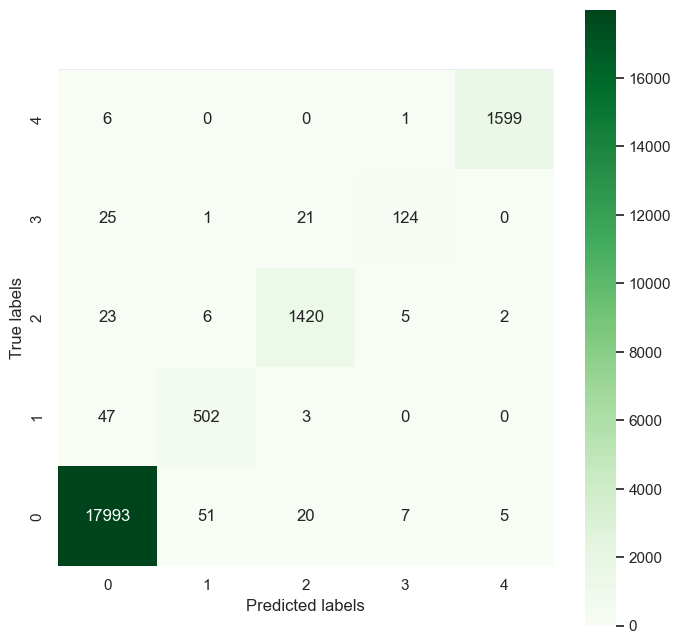

In [279]:
# predict
Y_pred = np.argmax(model.predict(x_test), axis=-1)
# Y_pred = model.predict_classes(X_test)
# plot confusion matrix
plotHeatMap(y_test, Y_pred)

In [280]:
# Per class accuracy printing function
def _report(TN, FP, FN, TP):
    TPR = TP/(TP+FN) if (TP+FN)!=0 else 0
    TNR = TN/(TN+FP) if (TN+FP)!=0 else 0
    PPV = TP/(TP+FP) if (TP+FP)!=0 else 0
    '''
    report = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN, 
              'TPR': TPR, 'Recall': TPR, 'Sensitivity': TPR,
              'TNR' : TNR, 'Specificity': TNR,
              'FPR': FP/(FP+TN) if (FP+TN)!=0 else 0,
              'FNR': FN/(FN+TP) if (FN+TP)!=0 else 0,
              'PPV': PPV, 'Precision': PPV,
              'F1 Score': 2*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy': (TP+TN)/(TP+FP+FN+TN)
             }'''

    report = {'Sensitivity (%)': TPR*100,
              'Specificity (%)': TNR*100,
              'F1 Score (%)': 2*100*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy (%)': (TP+TN)*100/(TP+FP+FN+TN)
             }
    return report

def multi_classification_report(y_test, y_pred, labels=None, encoded_labels=True, as_frame=False):
    """
    Args:
        y_test (ndarray)
        y_pred (ndarray)
        labels (list)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        as_fram (bool): If True, return type will be DataFrame
        
    Return:
        report (dict)
    """
    
    import numpy as np
    import pandas as pd
    from sklearn.metrics import multilabel_confusion_matrix
    
    conf_labels = None if encoded_labels else labels
    
    conf_mat = multilabel_confusion_matrix(y_test, y_pred, labels=conf_labels)
    report = dict()
    if labels == None:
        counter = np.arange(len(conf_mat))
    else:
        counter = labels
        
    for i, name in enumerate(counter):
        TN, FP, FN, TP = conf_mat[i].ravel()
        report[name] = _report(TN, FP, FN, TP)
    
    if as_frame:
        return pd.DataFrame(report)
    return report

In [281]:
# Per class performance
labels = ['N', 'S', 'V', 'F', 'Q']
Y_pred = np.argmax(model.predict(x_test), axis=-1)
multi_classification_report(y_test, Y_pred, labels=labels, encoded_labels=True, as_frame=True)

684/684 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step


N          S          V          F          Q
Sensitivity (%)         99.540828  90.942029  97.527473  72.514620  99.564134
Specificity (%)         97.331572  99.727815  99.784367  99.940065  99.965441
F1 Score (%)            99.491291  90.287770  97.260274  80.519481  99.564134
Per Class Accuracy (%)  99.158318  99.505970  99.634052  99.725539  99.935959

In [282]:
# Per class performance
labels = ['N', 'S', 'V', 'F', 'Q']
Y_pred = np.argmax(model2.predict(x_test), axis=-1)
multi_classification_report(y_test, Y_pred, labels=labels, encoded_labels=True, as_frame=True)

684/684 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step


N          S          V          F          Q
Sensitivity (%)         99.712326  89.311594  98.145604  77.777778  99.564134
Specificity (%)         97.384412  99.877986  99.774565  99.958506  99.985189
F1 Score (%)            99.582861  92.063492  97.509382  84.984026  99.688279
Per Class Accuracy (%)  99.309272  99.611180  99.666072  99.785005  99.954256

In [291]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Evaluate model on training and testing data
train_loss_cp, train_acc_cp = model2.evaluate(x_train, y_train, verbose=0)
test_loss_cp, test_acc_cp = model2.evaluate(x_test, y_test, verbose=0)

print(f"Training Accuracy: {train_acc_cp * 100:.2f}%")
print(f"Test Accuracy: {test_acc_cp * 100:.2f}%")
print(f"Training Loss: {train_loss_cp:.2f}")
print(f"Test Loss: {test_loss_cp:.2f}")

# Predictions
y_pred = model2.predict(x_test).argmax(axis=1)  # Predicted class labels
y_true = y_test.argmax(axis=1)  # True class labels

# Classification Metrics
classification_metrics = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(y_test.shape[1])])
print("Classification Report:")
print(classification_metrics)

# AUC-ROC Score
auc_roc = roc_auc_score(y_test, model2.predict(x_test), multi_class='ovr')
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Confusion Matrix and Specificity
conf_matrix = confusion_matrix(y_true, y_pred)
specificity = []
for i in range(len(conf_matrix)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))
overall_specificity = sum(specificity) / len(specificity)

# Print Specificity
print(f"Specificity: {overall_specificity:.4f}")

# Print Overall Metrics
print("\nOverall Metrics:")
print(f"Accuracy: {test_acc_cp * 100:.2f}%")
print(f"Precision, Recall (Sensitivity), F1-Score: See classification report above.")
print(f"Specificity: {overall_specificity:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")


Training Accuracy: 99.65%
Test Accuracy: 99.16%
Training Loss: 0.02
Test Loss: 0.05
684/684 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step


ValueError: Number of classes, 5, does not match size of target_names, 1. Try specifying the labels parameter

In [303]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Evaluate model on training and testing data
train_loss_cp, train_acc_cp = model2.evaluate(x_train, y_train, verbose=0)
test_loss_cp, test_acc_cp = model2.evaluate(x_test, y_test, verbose=0)

print(f"Training Accuracy: {train_acc_cp * 100:.2f}%")
print(f"Test Accuracy: {test_acc_cp * 100:.2f}%")
print(f"Training Loss: {train_loss_cp:.2f}")
print(f"Test Loss: {test_loss_cp:.2f}")

# Predictions
y_pred = model2.predict(x_test)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels
y_true = np.argmax(y_test, axis=1)  # True class labels

# Ensure the number of target names matches the number of classes
num_classes = y_test.shape[1]  # Number of classes in the dataset
target_names = [f'Class {i}' for i in range(num_classes)]

# Classification Metrics
classification_metrics = classification_report(y_true, y_pred_classes, target_names=target_names)
print("Classification Report:")
print(classification_metrics)

# AUC-ROC Score
# For multi-class, you need to use the "ovr" strategy and provide the probabilities
auc_roc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro')
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Confusion Matrix and Specificity
conf_matrix = confusion_matrix(y_true, y_pred_classes)
specificity = []
for i in range(len(conf_matrix)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))
overall_specificity = sum(specificity) / len(specificity)

# Print Specificity
print(f"Specificity: {overall_specificity:.4f}")

# Print Overall Metrics
print("\nOverall Metrics:")
print(f"Accuracy: {test_acc_cp * 100:.2f}%")
print(f"Precision, Recall (Sensitivity), F1-Score: See classification report above.")
print(f"Specificity: {overall_specificity:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")


Training Accuracy: 99.65%
Test Accuracy: 99.16%
Training Loss: 0.02
Test Loss: 0.05
684/684 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step


ValueError: Number of classes, 5, does not match size of target_names, 1. Try specifying the labels parameter

In [299]:
import numpy as np

# Debugging y_true and y_pred
print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
print(f"Unique classes in y_true: {np.unique(y_true)}")
print(f"Unique classes in y_pred: {np.unique(y_pred)}")

# Check if the number of target names matches the number of classes
num_classes_true = len(np.unique(y_true))
num_classes_pred = len(np.unique(y_pred))
print(f"Number of classes in y_true: {num_classes_true}")
print(f"Number of classes in target_names: {len(target_names)}")


y_true shape: (21861,), y_pred shape: (21861,)
Unique classes in y_true: [0]
Unique classes in y_pred: [0 1 2 3 4]
Number of classes in y_true: 1
Number of classes in target_names: 1


In [305]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Evaluate model on training and testing data
train_loss_cp, train_acc_cp = model2.evaluate(x_train, y_train, verbose=0)
test_loss_cp, test_acc_cp = model2.evaluate(x_test, y_test, verbose=0)

print(f"Training Accuracy: {train_acc_cp * 100:.2f}%")
print(f"Test Accuracy: {test_acc_cp * 100:.2f}%")
print(f"Training Loss: {train_loss_cp:.2f}")
print(f"Test Loss: {test_loss_cp:.2f}")

# Predictions
y_pred = model2.predict(x_test)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels
y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test  # Handle both one-hot and integer labels

# Ensure the number of target names matches the number of classes
num_classes = len(np.unique(y_true))  # Number of unique classes in the dataset
target_names = [f'Class {i}' for i in range(num_classes)]

# Classification Metrics
classification_metrics = classification_report(y_true, y_pred_classes, target_names=target_names)
print("Classification Report:")
print(classification_metrics)

# AUC-ROC Score
# For multi-class, you need to use the "ovr" strategy and provide the probabilities
auc_roc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro')
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Confusion Matrix and Specificity
conf_matrix = confusion_matrix(y_true, y_pred_classes)
specificity = []
for i in range(len(conf_matrix)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))
overall_specificity = sum(specificity) / len(specificity)

# Print Specificity
print(f"Specificity: {overall_specificity:.4f}")

# Print Overall Metrics
print("\nOverall Metrics:")
print(f"Accuracy: {test_acc_cp * 100:.2f}%")
print(f"Precision, Recall (Sensitivity), F1-Score: See classification report above.")
print(f"Specificity: {overall_specificity:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")


Training Accuracy: 99.65%
Test Accuracy: 99.16%
Training Loss: 0.02
Test Loss: 0.05
684/684 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step


ValueError: Number of classes, 5, does not match size of target_names, 1. Try specifying the labels parameter

In [310]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Evaluate model on training and testing data
train_loss_cp, train_acc_cp = model2.evaluate(x_train, y_train, verbose=0)
test_loss_cp, test_acc_cp = model2.evaluate(x_test, y_test, verbose=0)

print(f"Training Accuracy: {train_acc_cp * 100:.2f}%")
print(f"Test Accuracy: {test_acc_cp * 100:.2f}%")
print(f"Training Loss: {train_loss_cp:.2f}")
print(f"Test Loss: {test_loss_cp:.2f}")

# Predictions
y_pred = model2.predict(x_test)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels
y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test  # Handle both one-hot and integer labels

# Check unique classes in y_true and y_pred_classes
print(f"Unique classes in y_true: {np.unique(y_true)}")
print(f"Unique classes in y_pred_classes: {np.unique(y_pred_classes)}")

# Ensure the number of target names matches the number of classes
num_classes = len(np.unique(y_true))  # Number of unique classes in the dataset
target_names = [f'Class {i}' for i in range(num_classes)]

print(f"Number of classes: {num_classes}")
print(f"Target names: {target_names}")

# Classification Metrics
classification_metrics = classification_report(y_true, y_pred_classes, target_names=target_names)
print("Classification Report:")
print(classification_metrics)

# AUC-ROC Score
# For multi-class, you need to use the "ovr" strategy and provide the probabilities
auc_roc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro')
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Confusion Matrix and Specificity
conf_matrix = confusion_matrix(y_true, y_pred_classes)
specificity = []
for i in range(len(conf_matrix)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))
overall_specificity = sum(specificity) / len(specificity)

# Print Specificity
print(f"Specificity: {overall_specificity:.4f}")

# Print Overall Metrics
print("\nOverall Metrics:")
print(f"Accuracy: {test_acc_cp * 100:.2f}%")
print(f"Precision, Recall (Sensitivity), F1-Score: See classification report above.")
print(f"Specificity: {overall_specificity:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")


Training Accuracy: 99.65%
Test Accuracy: 99.16%
Training Loss: 0.02
Test Loss: 0.05
684/684 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step
Unique classes in y_true: [0]
Unique classes in y_pred_classes: [0 1 2 3 4]
Number of classes: 1
Target names: ['Class 0']


ValueError: Number of classes, 5, does not match size of target_names, 1. Try specifying the labels parameter

In [312]:
print(f"y_test shape: {y_test.shape}")
print(f"Unique values in y_test: {np.unique(y_test)}")
unique_classes = np.unique(y_true)
target_names = [f'Class {cls}' for cls in unique_classes]
print(f"Updated Target Names: {target_names}")


y_test shape: (21861, 1)
Unique values in y_test: [0. 1. 2. 3. 4.]
Updated Target Names: ['Class 0']


In [314]:
classification_metrics = classification_report(
    y_true,
    y_pred_classes,
    target_names=target_names,
    labels=unique_classes
)
print("Classification Report:")
print(classification_metrics)


Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.83      0.91     21861

   micro avg       1.00      0.83      0.91     21861
   macro avg       1.00      0.83      0.91     21861
weighted avg       1.00      0.83      0.91     21861



In [320]:
#MODEL 1 = LOGISTIC REGRES

In [1]:
print("Training Accuracy per Epoch:", train_losses)
print()
print("Training Loss per Epoch:", train_accuracies)

NameError: name 'train_losses' is not defined

In [3]:
one_acc=[0.794304, 0.800276, 0.803896, 0.805656, 0.806976, 0.807856, 0.808732, 0.80934, 0.809764, 0.810168, 0.81074, 0.811148, 0.811532, 0.811916, 0.812248, 0.812464, 0.812692, 0.812864, 0.813036, 0.813248]
one_loss=[0.6445234824104497, 0.6147749791914167, 0.6006380345022148, 0.5920020036225159, 0.5860385526743657, 0.5816085477056596, 0.5781547071315788, 0.5753674799328671, 0.5730589920463206, 0.5711075743563548, 0.5694304403446514, 0.5679690294216484, 0.5666806025160411, 0.5655331584484312, 0.5645022221866757, 0.563568740589149, 0.562717659077454, 0.5619369304664663, 0.5612168064367259, 0.5605493196688047]

In [323]:
#MODEL 2 = GRU

In [ ]:
print("Training Accuracy per Epoch:", train_losses_2)
print()
print("Training Loss per Epoch:", train_accuracies_2)


In [5]:
two_acc=[0.9497519731521606, 0.9758279919624329, 0.9812600016593933, 0.9837639927864075, 0.985696017742157, 0.9863479733467102, 0.9879559874534607, 0.9880759716033936, 0.988752007484436, 0.9893879890441895, 0.9901120066642761, 0.9901599884033203, 0.9907640218734741, 0.991100013256073, 0.9912199974060059, 0.991599977016449, 0.9919080138206482, 0.9922879934310913, 0.9921960234642029, 0.9922239780426025]
two_loss=[0.14878958463668823, 0.07200867682695389, 0.056406162679195404, 0.048450976610183716, 0.04321490600705147, 0.04130982980132103, 0.03690203279256821, 0.036017414182424545, 0.03378511220216751, 0.0316888727247715, 0.029825177043676376, 0.029907753691077232, 0.027822384610772133, 0.02693835459649563, 0.02631307952105999, 0.025469766929745674, 0.024269184097647667, 0.022758042439818382, 0.024006668478250504, 0.023401865735650063]


In [326]:
#MODEL 3 = DCN

In [346]:
print("Training Accuracy per Epoch:", train_losses_3)
print()
print("Training Loss per Epoch:", train_accuracies_3  )

Training Accuracy per Epoch: [0.41855117678642273, 0.22164642810821533, 0.17985156178474426, 0.15785396099090576, 0.14300638437271118, 0.13527639210224152, 0.12533311545848846, 0.11833655834197998, 0.11016669869422913, 0.10589313507080078, 0.09986422210931778, 0.09738669544458389, 0.09607178717851639, 0.08970153331756592, 0.08936809003353119, 0.08444444835186005, 0.0816313847899437, 0.08269838243722916, 0.07999605685472488, 0.07918395102024078]

Training Loss per Epoch: [0.9032203555107117, 0.9475651979446411, 0.9554336667060852, 0.9600713849067688, 0.9637972116470337, 0.9653865098953247, 0.967783510684967, 0.9691383838653564, 0.9715223908424377, 0.9720825552940369, 0.9729944467544556, 0.9741538763046265, 0.9747922420501709, 0.9759255647659302, 0.97535240650177, 0.9763815402984619, 0.9773325324058533, 0.9772152900695801, 0.9774628281593323, 0.9773455858230591]


In [7]:
three_acc= [0.9032203555107117, 0.9475651979446411, 0.9554336667060852, 0.9600713849067688, 0.9637972116470337, 0.9653865098953247, 0.967783510684967, 0.9691383838653564, 0.9715223908424377, 0.9720825552940369, 0.9729944467544556, 0.9741538763046265, 0.9747922420501709, 0.9759255647659302, 0.97535240650177, 0.9763815402984619, 0.9773325324058533, 0.9772152900695801, 0.9774628281593323, 0.9773455858230591]
three_loss=[0.41855117678642273, 0.22164642810821533, 0.17985156178474426, 0.15785396099090576, 0.14300638437271118, 0.13527639210224152, 0.12533311545848846, 0.11833655834197998, 0.11016669869422913, 0.10589313507080078, 0.09986422210931778, 0.09738669544458389, 0.09607178717851639, 0.08970153331756592, 0.08936809003353119, 0.08444444835186005, 0.0816313847899437, 0.08269838243722916, 0.07999605685472488, 0.07918395102024078]

In [329]:
#MODEL 4 = RNN

In [348]:
print("Training Accuracy per Epoch:", train_losses_4 )
print()
print("Training Loss per Epoch:", train_accuracies_4 )

Training Accuracy per Epoch: [1.1448893547058105, 1.265896201133728, 1.183169960975647, 1.129708170890808, 1.1857260465621948, 1.1846650838851929, 1.3111339807510376, 1.134522557258606, 1.0135095119476318, 1.2708361148834229, 1.2248022556304932, 1.2640950679779053, 1.2589040994644165, 1.3540977239608765, 1.3647104501724243, 1.33812415599823, 1.3475987911224365, 1.3484597206115723, 1.3219703435897827, 1.2400301694869995]

Training Loss per Epoch: [0.5418639779090881, 0.466264009475708, 0.514739990234375, 0.5426599979400635, 0.5120279788970947, 0.5039600133895874, 0.43688398599624634, 0.5344039797782898, 0.606719970703125, 0.4727320075035095, 0.4930639863014221, 0.4690600037574768, 0.4907039999961853, 0.4286639988422394, 0.4127880036830902, 0.4194200038909912, 0.41579198837280273, 0.43505600094795227, 0.4391759932041168, 0.48278799653053284]


In [9]:
four_acc=[0.5418639779090881, 0.466264009475708, 0.514739990234375, 0.5426599979400635, 0.5120279788970947, 0.5039600133895874, 0.43688398599624634, 0.5344039797782898, 0.606719970703125, 0.4727320075035095, 0.4930639863014221, 0.4690600037574768, 0.4907039999961853, 0.4286639988422394, 0.4127880036830902, 0.4194200038909912, 0.41579198837280273, 0.43505600094795227, 0.4391759932041168, 0.48278799653053284]
four_loss=[1.1448893547058105, 1.265896201133728, 1.183169960975647, 1.129708170890808, 1.1857260465621948, 1.1846650838851929, 1.3111339807510376, 1.134522557258606, 1.0135095119476318, 1.2708361148834229, 1.2248022556304932, 1.2640950679779053, 1.2589040994644165, 1.3540977239608765, 1.3647104501724243, 1.33812415599823, 1.3475987911224365, 1.3484597206115723, 1.3219703435897827, 1.2400301694869995]

In [332]:
#MODEL 5 = RANDOM FOREST

In [350]:
print("Training Accuracy per Epoch:",train_accuracies_5 )
print()
print("Training Loss per Epoch:", train_losses_5 )

Training Accuracy per Epoch: [0.922036, 0.933372, 0.934248, 0.9338, 0.934548, 0.937436, 0.937244, 0.937412, 0.937732, 0.937908, 0.937784, 0.937872, 0.939476, 0.940776, 0.939736, 0.939224, 0.938128, 0.93852, 0.938712, 0.938576]

Training Loss per Epoch: [0.28170702572103173, 0.2682897313365634, 0.26553924025999387, 0.2692522748300807, 0.2683229381515832, 0.26224909559317294, 0.26128089037323604, 0.26258238514786864, 0.2633626300087603, 0.2628886475525811, 0.26186480355941716, 0.26208538989936586, 0.26042096680500626, 0.2586163186462855, 0.26087766636482357, 0.2621051306043934, 0.2633422968003297, 0.2638200199472451, 0.26364201487199423, 0.26331292115350935]


In [11]:
five_acc=[0.922036, 0.933372, 0.934248, 0.9338, 0.934548, 0.937436, 0.937244, 0.937412, 0.937732, 0.937908, 0.937784, 0.937872, 0.939476, 0.940776, 0.939736, 0.939224, 0.938128, 0.93852, 0.938712, 0.938576]
five_loss=[0.28170702572103173, 0.2682897313365634, 0.26553924025999387, 0.2692522748300807, 0.2683229381515832, 0.26224909559317294, 0.26128089037323604, 0.26258238514786864, 0.2633626300087603, 0.2628886475525811, 0.26186480355941716, 0.26208538989936586, 0.26042096680500626, 0.2586163186462855, 0.26087766636482357, 0.2621051306043934, 0.2633422968003297, 0.2638200199472451, 0.26364201487199423, 0.26331292115350935]


In [335]:
#MODEL 6 = CNN+GRU

In [352]:
print("Training Accuracy per Epoch:",  training_accuracy_6)
print()
print("Training Loss per Epoch:",  training_loss_6)

Training Accuracy per Epoch: [0.728663980960846, 0.8683159947395325, 0.9056599736213684, 0.9265639781951904, 0.940123975276947, 0.9488760232925415, 0.9542120099067688, 0.9581519961357117, 0.9631239771842957, 0.9657599925994873, 0.968288004398346, 0.9703879952430725, 0.9719120264053345, 0.9741320013999939, 0.9760040044784546, 0.9774960279464722, 0.9791039824485779, 0.9798640012741089, 0.9812600016593933, 0.9813479781150818]

Training Loss per Epoch: [0.6932276487350464, 0.3514583706855774, 0.2621152102947235, 0.213726207613945, 0.17899492383003235, 0.15392258763313293, 0.13922566175460815, 0.12570008635520935, 0.11237394064664841, 0.10492122918367386, 0.09623057395219803, 0.09030167758464813, 0.08533963561058044, 0.07904238253831863, 0.07313830405473709, 0.06923767179250717, 0.06401797384023666, 0.06180613487958908, 0.05836976319551468, 0.0568392314016819]


In [13]:
six_acc=[0.728663980960846, 0.8683159947395325, 0.9056599736213684, 0.9265639781951904, 0.940123975276947, 0.9488760232925415, 0.9542120099067688, 0.9581519961357117, 0.9631239771842957, 0.9657599925994873, 0.968288004398346, 0.9703879952430725, 0.9719120264053345, 0.9741320013999939, 0.9760040044784546, 0.9774960279464722, 0.9791039824485779, 0.9798640012741089, 0.9812600016593933, 0.9813479781150818]
six_loss= [0.6932276487350464, 0.3514583706855774, 0.2621152102947235, 0.213726207613945, 0.17899492383003235, 0.15392258763313293, 0.13922566175460815, 0.12570008635520935, 0.11237394064664841, 0.10492122918367386, 0.09623057395219803, 0.09030167758464813, 0.08533963561058044, 0.07904238253831863, 0.07313830405473709, 0.06923767179250717, 0.06401797384023666, 0.06180613487958908, 0.05836976319551468, 0.0568392314016819]

In [338]:
#MODEL 7 = CAT

In [340]:
print("Training Accuracy per Epoch:", training_accuracy_7)
print("Training Loss per Epoch:", training_loss_7)

Training Accuracy per Epoch: [0.9273675680160522, 0.975141167640686, 0.9823886752128601, 0.9860767722129822, 0.9879779815673828, 0.9887784719467163, 0.990050733089447, 0.990608274936676, 0.9912943840026855, 0.9919948577880859, 0.9919233918190002, 0.9926953315734863, 0.9938532114028931, 0.993524432182312, 0.9943535327911377, 0.9942248463630676, 0.9951969385147095, 0.9947251677513123, 0.9951111674308777, 0.9956114888191223]
Training Loss per Epoch: [0.26658445596694946, 0.09346409887075424, 0.06378432363271713, 0.05237242206931114, 0.0438242070376873, 0.03878050297498703, 0.03539082780480385, 0.03130434453487396, 0.0280882827937603, 0.025061020627617836, 0.025613343343138695, 0.02202187478542328, 0.019231267273426056, 0.020014600828289986, 0.016758129000663757, 0.01765352487564087, 0.014806714840233326, 0.016089661046862602, 0.015069253742694855, 0.013026365078985691]


In [15]:
seven_acc=[0.9273675680160522, 0.975141167640686, 0.9823886752128601, 0.9860767722129822, 0.9879779815673828, 0.9887784719467163, 0.990050733089447, 0.990608274936676, 0.9912943840026855, 0.9919948577880859, 0.9919233918190002, 0.9926953315734863, 0.9938532114028931, 0.993524432182312, 0.9943535327911377, 0.9942248463630676, 0.9951969385147095, 0.9947251677513123, 0.9951111674308777, 0.9956114888191223]
seven_loss=[0.26658445596694946, 0.09346409887075424, 0.06378432363271713, 0.05237242206931114, 0.0438242070376873, 0.03878050297498703, 0.03539082780480385, 0.03130434453487396, 0.0280882827937603, 0.025061020627617836, 0.025613343343138695, 0.02202187478542328, 0.019231267273426056, 0.020014600828289986, 0.016758129000663757, 0.01765352487564087, 0.014806714840233326, 0.016089661046862602, 0.015069253742694855, 0.013026365078985691]

In [88]:
print(len(one_acc), len(two_acc), len(three_acc), len(four_acc), len(five_acc), len(six_acc), len(seven_acc))

20 20 20 20 20 20 20


In [90]:
print(len(one_loss), len(two_loss), len(three_loss), len(four_loss), len(five_loss), len(six_loss), len(seven_loss))

20 20 20 20 20 20 20


In [21]:
import matplotlib.pyplot as plt

training_accuracies = [
    one_acc, two_acc, three_acc, four_acc, five_acc, six_acc, seven_acc
]
training_losses = [
    one_loss, two_loss, three_loss, four_loss, five_loss, six_loss, seven_loss
]

# Model labels for the legend
model_labels = [
    "Logistic Regression", "GRU", "DCN", "RNN", "Random Forest", "CNN+GRU", "CAT"
]

# Number of epochs
epochs = range(1, 21)

# Plot Training Accuracies
plt.figure(figsize=(10, 6))
for i, acc in enumerate(training_accuracies):
    plt.plot(epochs, acc, label=model_labels[i])
plt.title('Training Accuracies Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\training_accuracies.png', dpi=300)
plt.close()

# Plot Training Losses
plt.figure(figsize=(10, 6))
for i, loss in enumerate(training_losses):
    plt.plot(epochs, loss, label=model_labels[i])
plt.title('Training Losses Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\training_losses.png', dpi=300)
plt.close()

print("Plots saved as 'new_training_acc.png' and 'new_training_loss.png'")


Plots saved as 'new_training_acc.png' and 'new_training_loss.png'


In [29]:
import matplotlib.pyplot as plt

training_accuracies = [
    one_acc, two_acc, three_acc, four_acc, five_acc, six_acc, seven_acc
]
training_losses = [
    one_loss, two_loss, three_loss, four_loss, five_loss, six_loss, seven_loss
]

# Model labels for the legend
model_labels = [
    "Logistic Regression", "GRU", "DCN", "RNN", "Random Forest", "CNN+GRU", "CAT"
]

# Use only even-numbered epochs
epochs = list(range(2, 21, 2))

# Plot Training Accuracies
plt.figure(figsize=(10, 6))
for i, acc in enumerate(training_accuracies):
    plt.plot(epochs, acc[:len(epochs)], label=model_labels[i])  # Slice acc data
plt.xticks(epochs)  # Set x-axis ticks to whole numbers
plt.title('Training Accuracies Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\training_accuracies.png', dpi=300)
plt.close()

# Plot Training Losses
plt.figure(figsize=(10, 6))
for i, loss in enumerate(training_losses):
    plt.plot(epochs, loss[:len(epochs)], label=model_labels[i])  # Slice loss data
plt.xticks(epochs)  # Set x-axis ticks to whole numbers
plt.title('Training Losses Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='lower right', fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\training_losses.png', dpi=300)
plt.close()

print("Plots saved as 'training_accuracies.png' and 'training_losses.png'")


Plots saved as 'training_accuracies.png' and 'training_losses.png'


In [ ]:
#INCREASE SIZE OF LEGEND

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

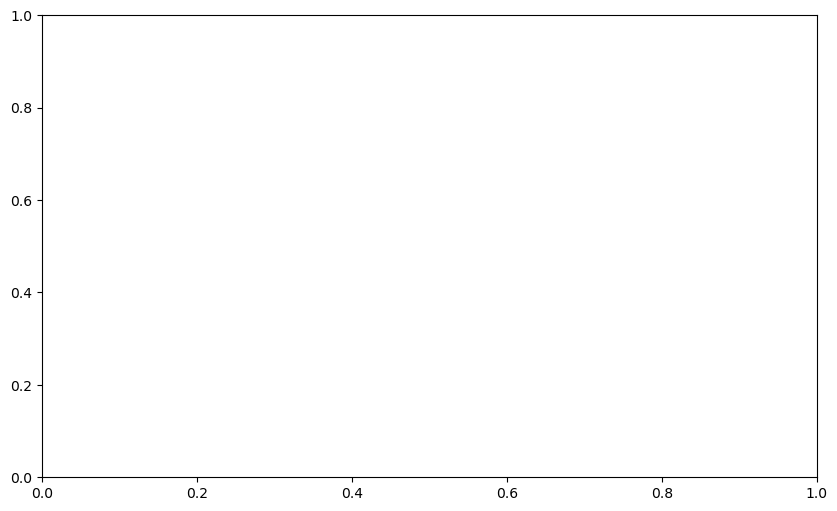

In [27]:
# Plot Training Accuracies
plt.figure(figsize=(10, 6))
for i, acc in enumerate(training_accuracies):
    plt.plot(epochs, acc, label=model_labels[i], linewidth=1)
plt.title('Training Accuracies Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=16)  # Increase font size
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\size_training_accuracies.png', dpi=300)
plt.close()

# Plot Training Losses
plt.figure(figsize=(10, 6))
for i, loss in enumerate(training_losses):
    plt.plot(epochs, loss, label=model_labels[i], linewidth=1)
plt.title('Training Losses Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='lower right', fontsize=16)  # Increase font size
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\size_training_losses.png', dpi=300)
plt.close()

print("Plots saved as 'size_training_acc.png' and 'size_training_losses.png'")


In [25]:
import matplotlib.pyplot as plt

training_accuracies = [
    train_accuracies, train_accuracies_2, train_accuracies_3,
    train_accuracies_4, train_accuracies_5, training_accuracy_6,
    training_accuracy_7
]
training_losses = [
    train_losses, train_losses_2, train_losses_3,
    train_losses_4, train_losses_5, training_loss_6,
     training_loss_7
]

# Model labels for the legend
model_labels = [
    "Logistic Regression", "GRU", "DCN", "RNN", "Random Forest", "CNN+GRU", "CAT"
]

# Number of epochs
epochs = range(1, len(train_accuracies) + 1)

# Plot Training Accuracies
plt.figure(figsize=(10, 6))
for i, acc in enumerate(training_accuracies):
    plt.plot(epochs, acc, label=model_labels[i])
plt.title('Training Accuracies Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('training_accuracies.png', dpi=300)
plt.close()

# Plot Training Losses
plt.figure(figsize=(10, 6))
for i, loss in enumerate(training_losses):
    plt.plot(epochs, loss, label=model_labels[i])
plt.title('Training Losses Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('training_losses.png', dpi=300)
plt.close()

print("Plots saved as 'training_accuracies.png' and 'training_losses.png'")


NameError: name 'train_accuracies' is not defined